In [2]:
import os
import yaml
import json

os.chdir('/home/ray/DeepMSN/')

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets.topic_datasets import TopicDataset
# from models.deepmsn import DeepMSN

device = torch.device(f'cuda:0')
print(f"Using {device} device")

Using cuda:0 device


In [4]:
with open('configs/config_dm-furlanis.yaml', 'r') as f:
    config = yaml.safe_load(f)

checkpoint_path = config.get('train').get('checkpoint').get('path')
checkpoint_path

'checkpoints/dm_furlanis_2025-05-29_15-32-41'

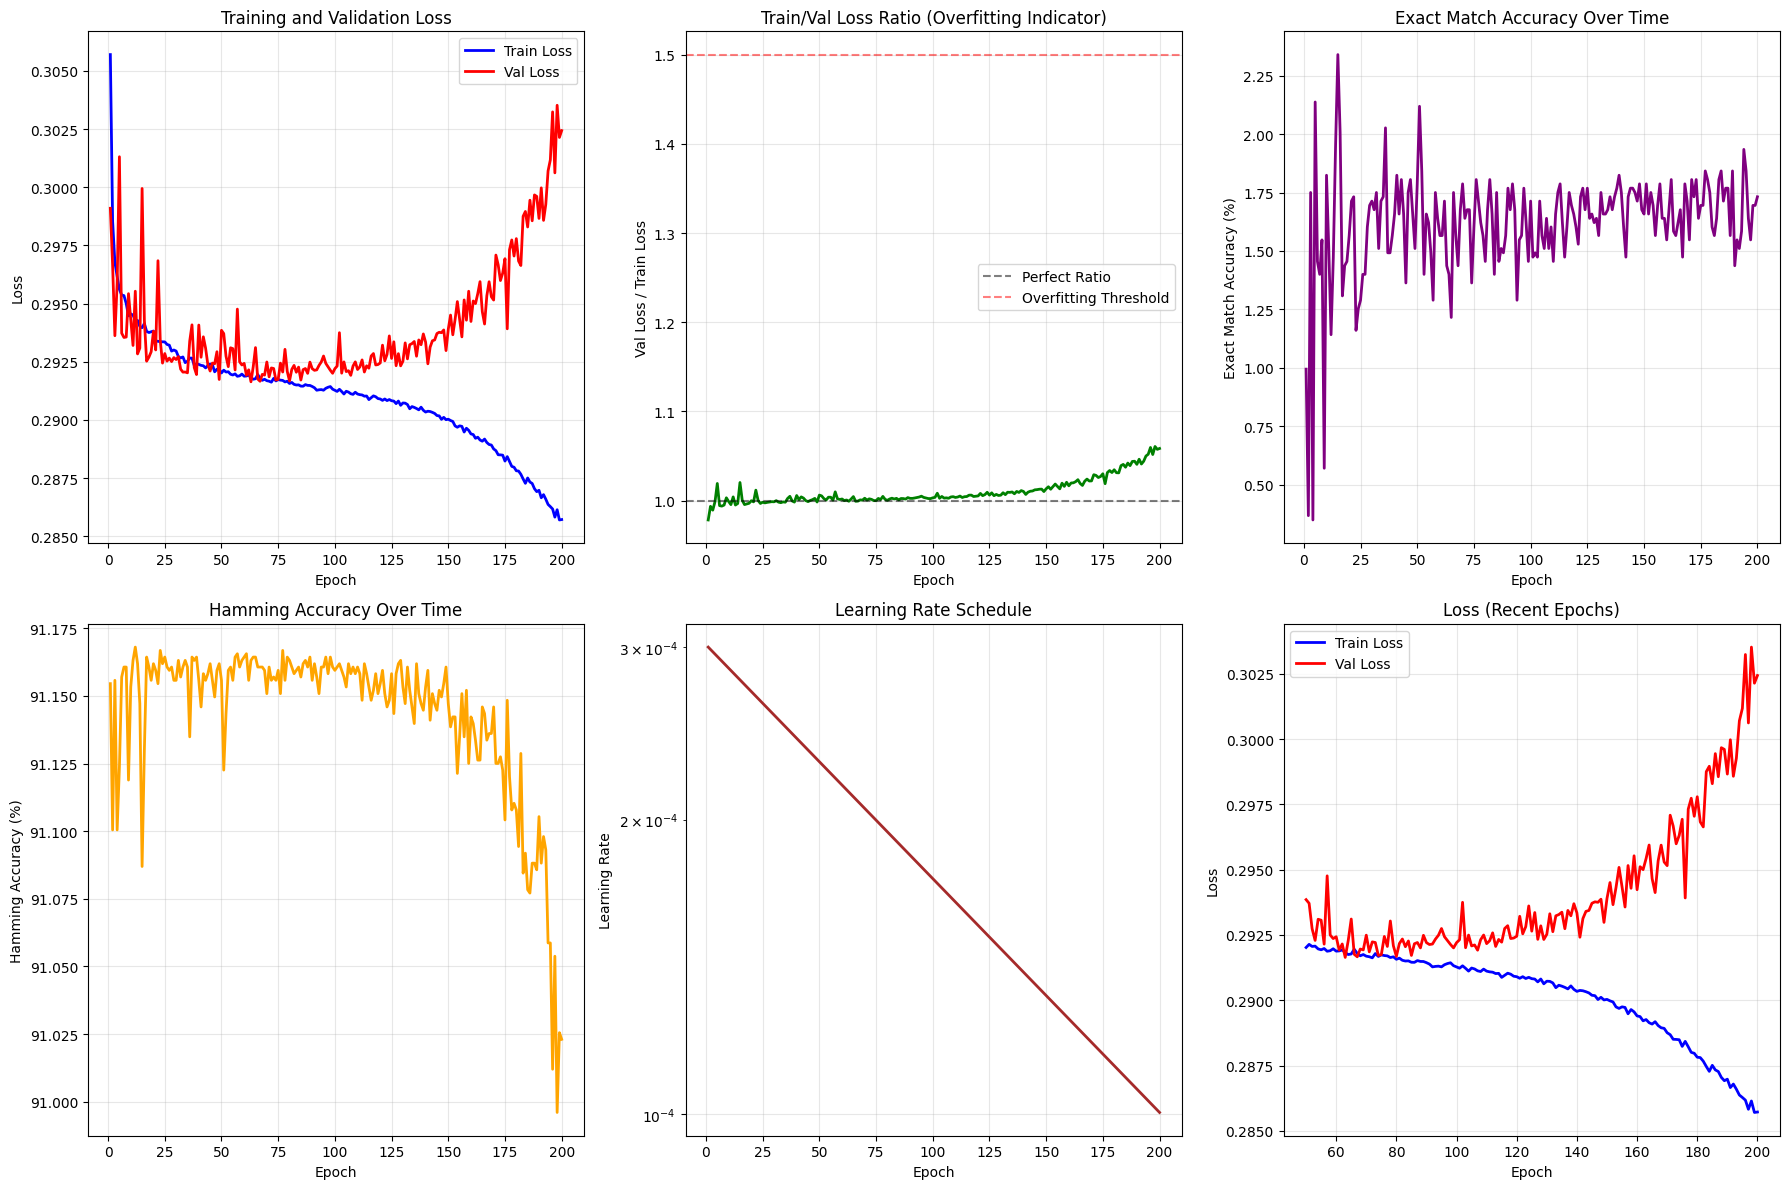

Training Summary:
Initial Train Loss: 0.305702
Final Train Loss: 0.285722
Initial Val Loss: 0.299098
Final Val Loss: 0.302436
Best Val Loss: 0.291642 (Epoch 63)
Best Exact Match Acc: 0.0234 (Epoch 15)
Best Hamming Acc: 0.9117 (Epoch 12)
Final Train/Val Ratio: 1.058


In [4]:
# Add this cell to your notebook to plot training curves

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the training log
training_df = pd.read_csv(f'{checkpoint_path}/training_log.csv')

# Create comprehensive training plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training and Validation Loss
axes[0, 0].plot(training_df['epoch'], training_df['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(training_df['epoch'], training_df['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Train/Val Loss Ratio (Overfitting indicator)
axes[0, 1].plot(training_df['epoch'], training_df['train_val_ratio'], 'g-', linewidth=2)
axes[0, 1].axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Perfect Ratio')
axes[0, 1].axhline(y=1.5, color='r', linestyle='--', alpha=0.5, label='Overfitting Threshold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Val Loss / Train Loss')
axes[0, 1].set_title('Train/Val Loss Ratio (Overfitting Indicator)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Exact Match Accuracy
axes[0, 2].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 'purple', linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Exact Match Accuracy (%)')
axes[0, 2].set_title('Exact Match Accuracy Over Time')
axes[0, 2].grid(True, alpha=0.3)

# 4. Hamming Accuracy
axes[1, 0].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 'orange', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Hamming Accuracy (%)')
axes[1, 0].set_title('Hamming Accuracy Over Time')
axes[1, 0].grid(True, alpha=0.3)

# 5. Learning Rate Schedule
axes[1, 1].plot(training_df['epoch'], training_df['learning_rate'], 'brown', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

# 6. Loss Comparison (zoomed view of recent epochs)
recent_epochs = training_df['epoch'] >= 50  # Show last part of training
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].set_title('Loss (Recent Epochs)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Summary:")
print(f"Initial Train Loss: {training_df['train_loss'].iloc[0]:.6f}")
print(f"Final Train Loss: {training_df['train_loss'].iloc[-1]:.6f}")
print(f"Initial Val Loss: {training_df['val_loss'].iloc[0]:.6f}")
print(f"Final Val Loss: {training_df['val_loss'].iloc[-1]:.6f}")
print(f"Best Val Loss: {training_df['val_loss'].min():.6f} (Epoch {training_df.loc[training_df['val_loss'].idxmin(), 'epoch']})")
print(f"Best Exact Match Acc: {training_df['exact_match_acc'].max():.4f} (Epoch {training_df.loc[training_df['exact_match_acc'].idxmax(), 'epoch']})")
print(f"Best Hamming Acc: {training_df['hamming_acc'].max():.4f} (Epoch {training_df.loc[training_df['hamming_acc'].idxmax(), 'epoch']})")
print(f"Final Train/Val Ratio: {training_df['train_val_ratio'].iloc[-1]:.3f}")

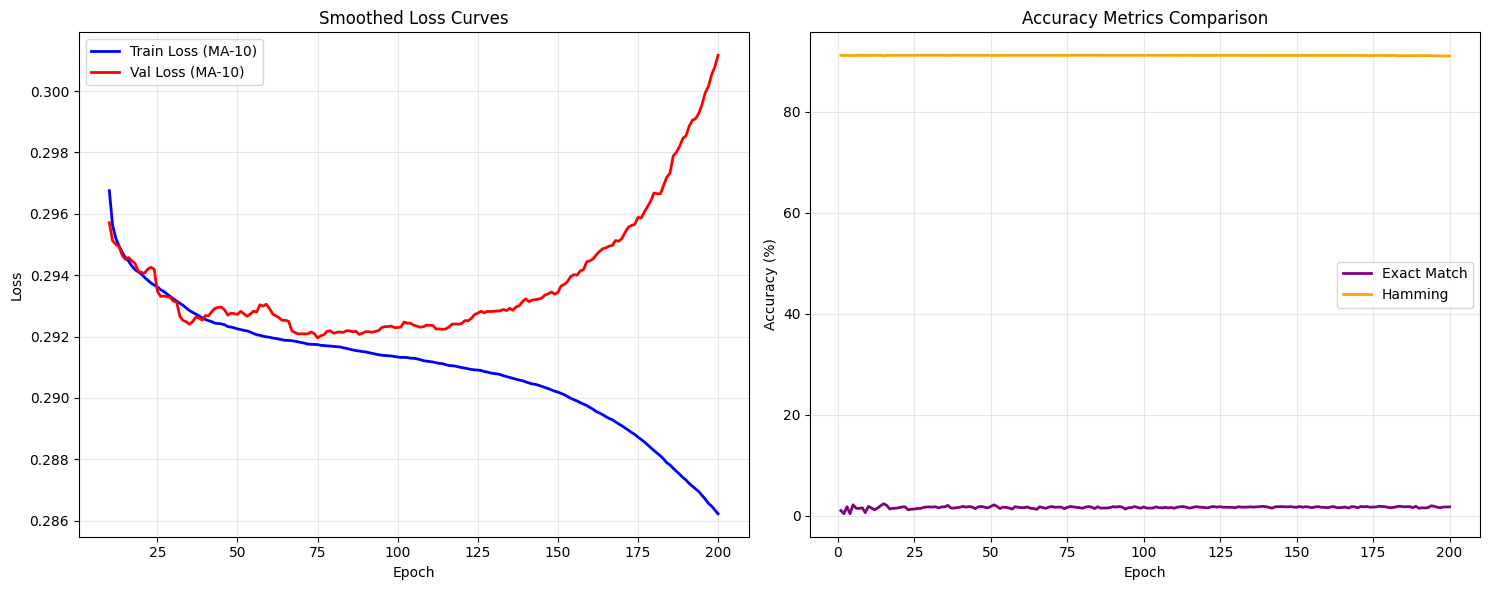

In [5]:
# Additional analysis plots

# Plot 1: Loss improvement over time
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Moving average to smooth curves
window = 10
train_loss_smooth = training_df['train_loss'].rolling(window=window).mean()
val_loss_smooth = training_df['val_loss'].rolling(window=window).mean()

axes[0].plot(training_df['epoch'], train_loss_smooth, 'b-', label=f'Train Loss (MA-{window})', linewidth=2)
axes[0].plot(training_df['epoch'], val_loss_smooth, 'r-', label=f'Val Loss (MA-{window})', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Smoothed Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 
             'purple', label='Exact Match', linewidth=2)
axes[1].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 
             'orange', label='Hamming', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Metrics Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

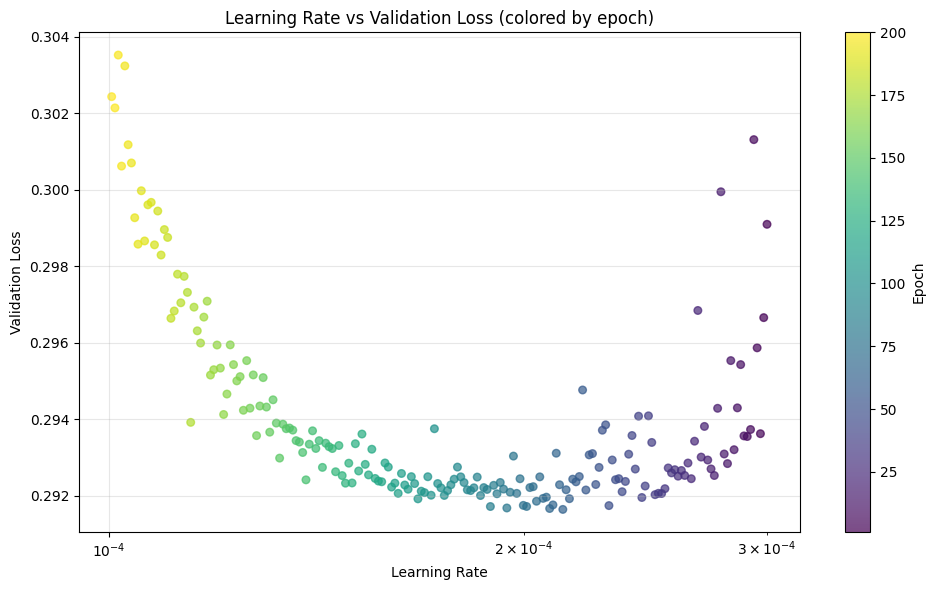

In [6]:
# Learning rate vs loss correlation
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create scatter plot with color gradient
scatter = ax.scatter(training_df['learning_rate'], training_df['val_loss'], 
                    c=training_df['epoch'], cmap='viridis', alpha=0.7, s=30)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.set_xscale('log')
ax.set_title('Learning Rate vs Validation Loss (colored by epoch)')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Epoch')

plt.tight_layout()
plt.show()

In [7]:
# # Training phases analysis
# print("Training Phases Analysis:")
# print("=" * 50)

# # Phase 1: Initial training (epochs 1-50)
# phase1 = training_df[training_df['epoch'] <= 50]
# print(f"Phase 1 (Epochs 1-50):")
# print(f"  Loss reduction: {phase1['train_loss'].iloc[0]:.4f} → {phase1['train_loss'].iloc[-1]:.4f}")
# print(f"  Val loss reduction: {phase1['val_loss'].iloc[0]:.4f} → {phase1['val_loss'].iloc[-1]:.4f}")
# print(f"  Accuracy improvement: {phase1['exact_match_acc'].iloc[0]:.4f} → {phase1['exact_match_acc'].iloc[-1]:.4f}")

# # Phase 2: Middle training (epochs 51-200)
# phase2 = training_df[(training_df['epoch'] > 50) & (training_df['epoch'] <= 200)]
# print(f"\nPhase 2 (Epochs 51-200):")
# print(f"  Loss reduction: {phase2['train_loss'].iloc[0]:.4f} → {phase2['train_loss'].iloc[-1]:.4f}")
# print(f"  Val loss reduction: {phase2['val_loss'].iloc[0]:.4f} → {phase2['val_loss'].iloc[-1]:.4f}")
# print(f"  Best accuracy: {phase2['exact_match_acc'].max():.4f}")

# # Phase 3: Fine-tuning (epochs 201-300)
# phase3 = training_df[training_df['epoch'] > 200]
# print(f"\nPhase 3 (Epochs 201-300):")
# print(f"  Loss reduction: {phase3['train_loss'].iloc[0]:.4f} → {phase3['train_loss'].iloc[-1]:.4f}")
# print(f"  Val loss reduction: {phase3['val_loss'].iloc[0]:.4f} → {phase3['val_loss'].iloc[-1]:.4f}")
# print(f"  Best accuracy: {phase3['exact_match_acc'].max():.4f}")

# # Identify potential overfitting
# overfitting_epochs = training_df[training_df['train_val_ratio'] > 1.5]
# if len(overfitting_epochs) > 0:
#     print(f"\nPotential overfitting detected in {len(overfitting_epochs)} epochs:")
#     print(f"  First occurrence: Epoch {overfitting_epochs['epoch'].iloc[0]}")
#     print(f"  Worst ratio: {overfitting_epochs['train_val_ratio'].max():.3f} at epoch {overfitting_epochs.loc[overfitting_epochs['train_val_ratio'].idxmax(), 'epoch']}")
# else:
#     print(f"\nNo significant overfitting detected (all ratios < 1.5)")

Training Phases Analysis:
Phase 1 (Epochs 1-50):
  Loss reduction: 0.3057 → 0.2920
  Val loss reduction: 0.2991 → 0.2939
  Accuracy improvement: 0.0099 → 0.0179

Phase 2 (Epochs 51-200):
  Loss reduction: 0.2921 → 0.2857
  Val loss reduction: 0.2937 → 0.3024
  Best accuracy: 0.0212

Phase 3 (Epochs 201-300):


IndexError: single positional indexer is out-of-bounds

In [5]:
# Determine model used
model_arch = config.get('train').get('model')

if model_arch == 'DeepMSN':
    from models.deepmsn import DeepMSN
    ModelClass = DeepMSN
elif model_arch == 'DeepFlyBrain':
    from models.deepflybrain import DeepFlyBrain
    ModelClass = DeepFlyBrain

In [6]:
# Load model from checkpoint
state_dict = torch.load(f'{checkpoint_path}/final_model.pth')

model = ModelClass(config=config).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [12]:
# Resume dataset and dataloaders from saved indices
batch_size = 64
dataset = TopicDataset(config=config['dataset'])

with open(f'{checkpoint_path}/test_indices.txt', 'r') as f:
    test_indices = [int(line.strip()) for line in f.readlines()]
test_dataset = torch.utils.data.Subset(dataset, test_indices)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Entire dataset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Test dataset

In [13]:
# Loss function
# Label smoothing loss to prevent overconfident predictions
class LabelSmoothingBCELoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        # Apply label smoothing: y_smooth = y * (1-α) + α/2
        target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
        return self.bce(pred, target_smooth)

loss_fn = LabelSmoothingBCELoss(smoothing=0.1)

In [14]:
# Evaluate model on entire dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix

In [16]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 3.0275533e-13 0.9999664
Prediction shape: (36190, 15)
Target shape: (36190, 15)


In [17]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0865
Topic 1: 0.0902
Topic 2: 0.0964
Topic 3: 0.0912
Topic 4: 0.0930
Topic 5: 0.0882
Topic 6: 0.0824
Topic 7: 0.0924
Topic 8: 0.0866
Topic 9: 0.0883
Topic 10: 0.0894
Topic 11: 0.0912
Topic 12: 0.0888
Topic 13: 0.0897
Topic 14: 0.0885


In [18]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[32968    92]
 [ 3069    61]]

Topic 1:
[[32849    78]
 [ 3191    72]]

Topic 2:
[[32302   401]
 [ 2578   909]]

Topic 3:
[[32882     8]
 [ 3295     5]]

Topic 4:
[[32804    19]
 [ 3352    15]]

Topic 5:
[[32935    63]
 [ 3164    28]]

Topic 6:
[[33191    18]
 [ 2957    24]]

Topic 7:
[[32772    74]
 [ 3309    35]]

Topic 8:
[[33040    17]
 [ 3118    15]]

Topic 9:
[[32923    71]
 [ 3155    41]]

Topic 10:
[[32939    14]
 [ 3220    17]]

Topic 11:
[[32869    20]
 [ 3288    13]]

Topic 12:
[[32968    10]
 [ 3197    15]]

Topic 13:
[[32926    17]
 [ 3232    15]]

Topic 14:
[[32939    49]
 [ 3179    23]]



Evaluating 15 topics...
Evaluating topic 0
Topic 0 - auROC: 0.6247, auPR: 0.1480, F1: 0.0372


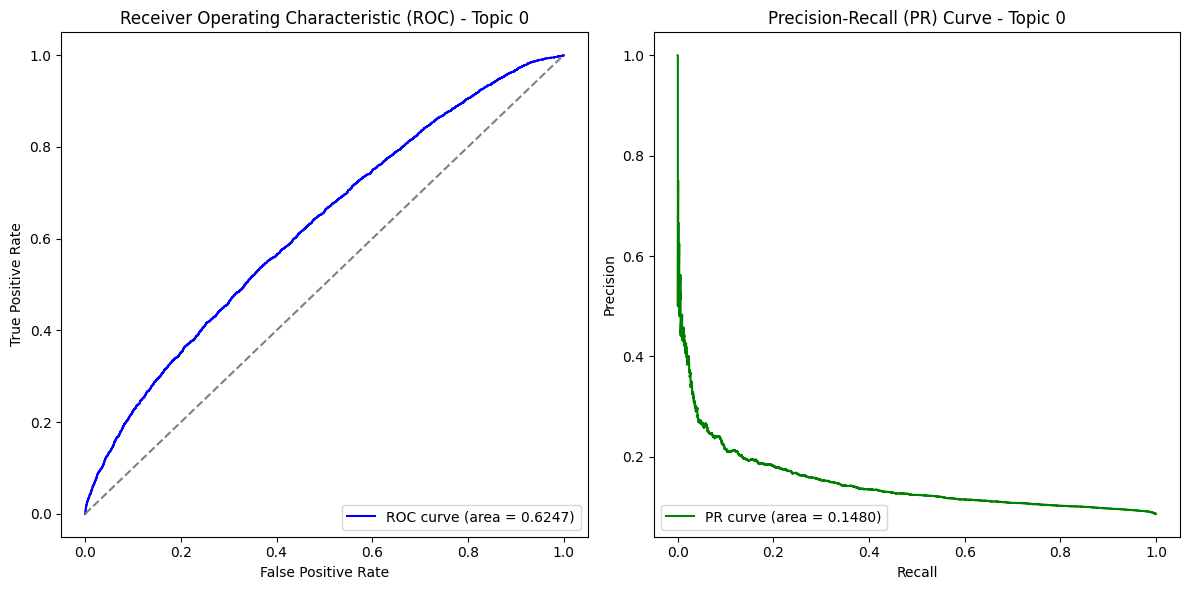

Evaluating topic 1
Topic 1 - auROC: 0.7188, auPR: 0.2109, F1: 0.0422


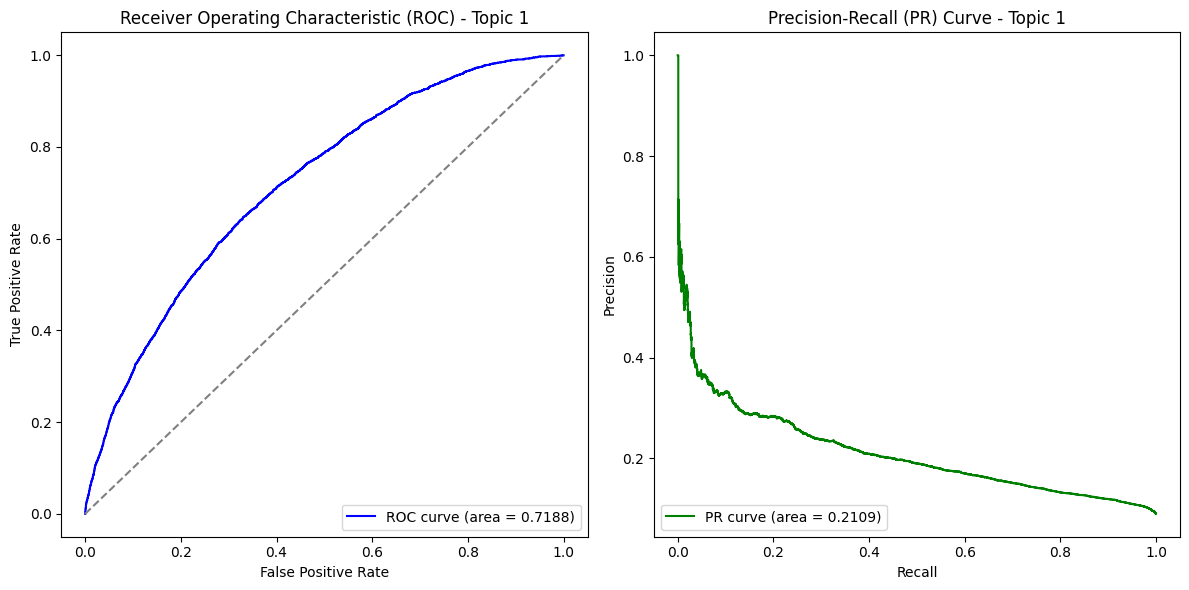

Evaluating topic 2
Topic 2 - auROC: 0.7351, auPR: 0.3995, F1: 0.3790


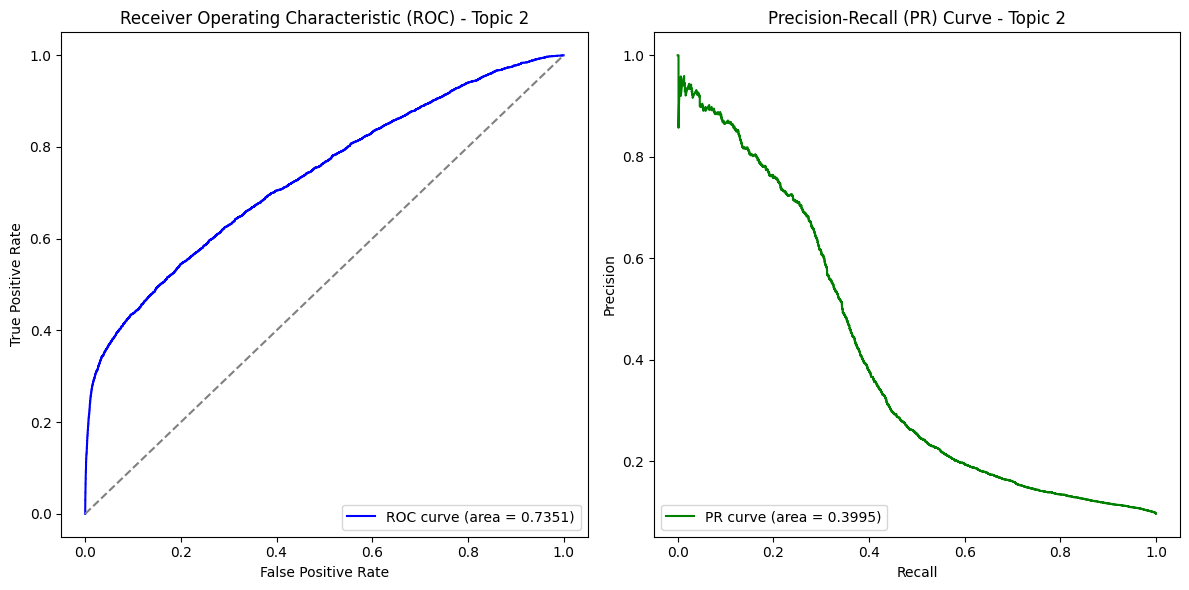

Evaluating topic 3
Topic 3 - auROC: 0.6375, auPR: 0.1434, F1: 0.0030


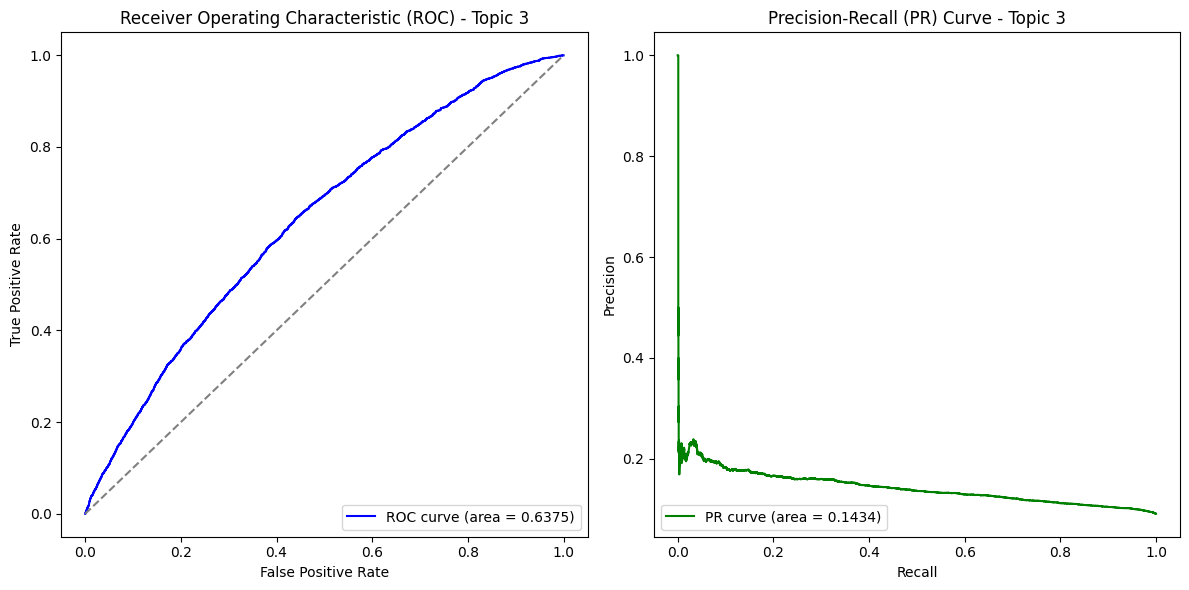

Evaluating topic 4
Topic 4 - auROC: 0.6325, auPR: 0.1418, F1: 0.0088


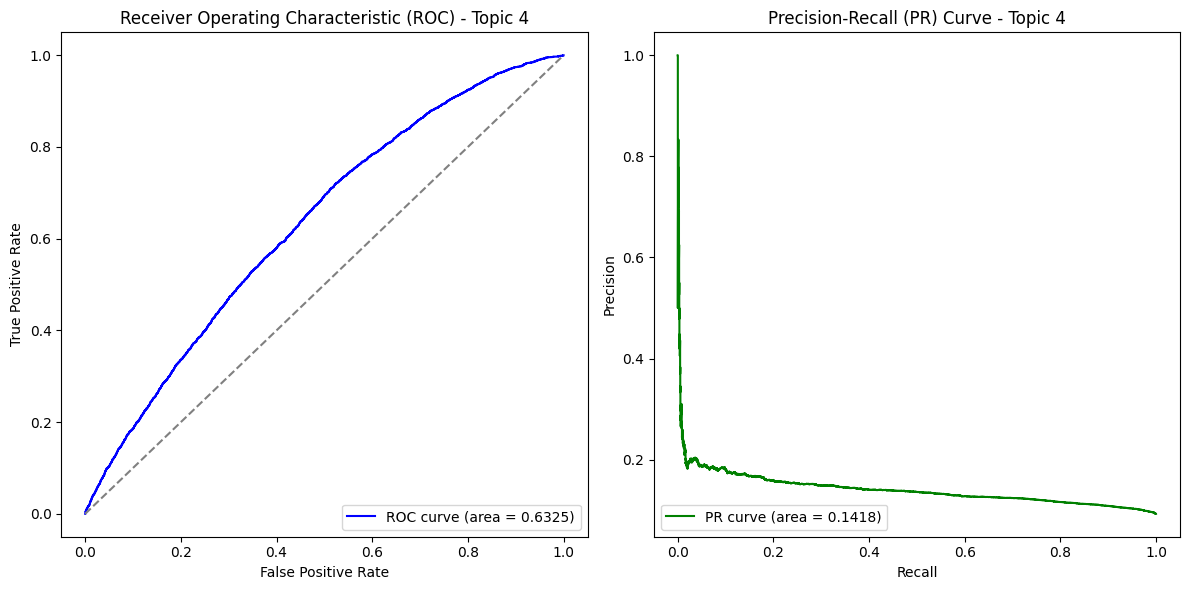

Evaluating topic 5
Topic 5 - auROC: 0.6296, auPR: 0.1406, F1: 0.0171


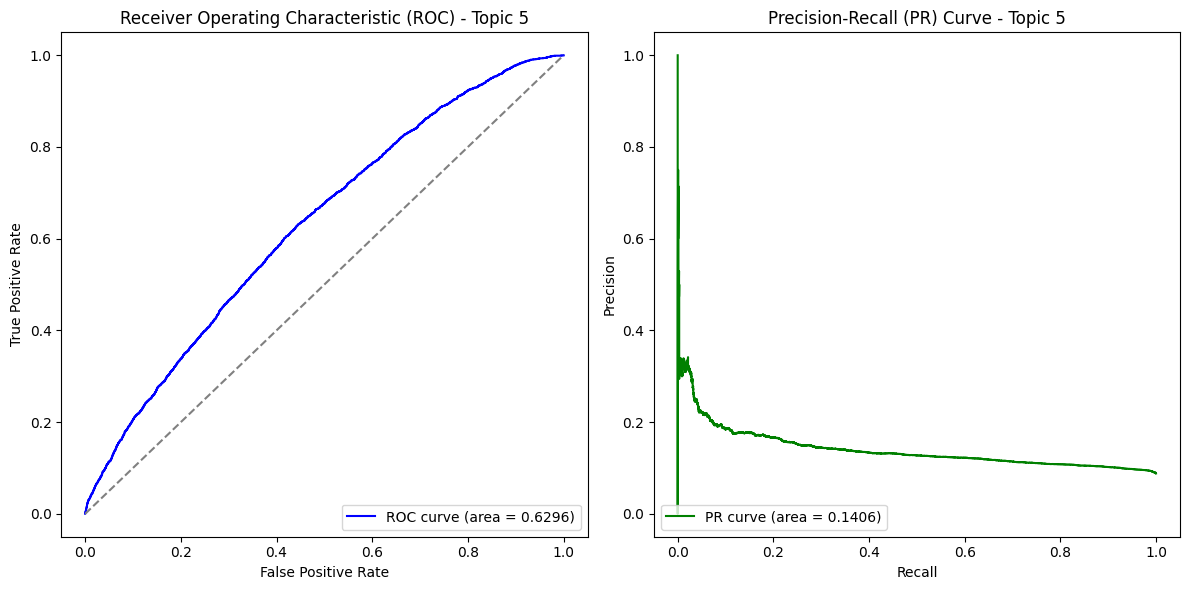

Evaluating topic 6
Topic 6 - auROC: 0.6494, auPR: 0.1457, F1: 0.0159


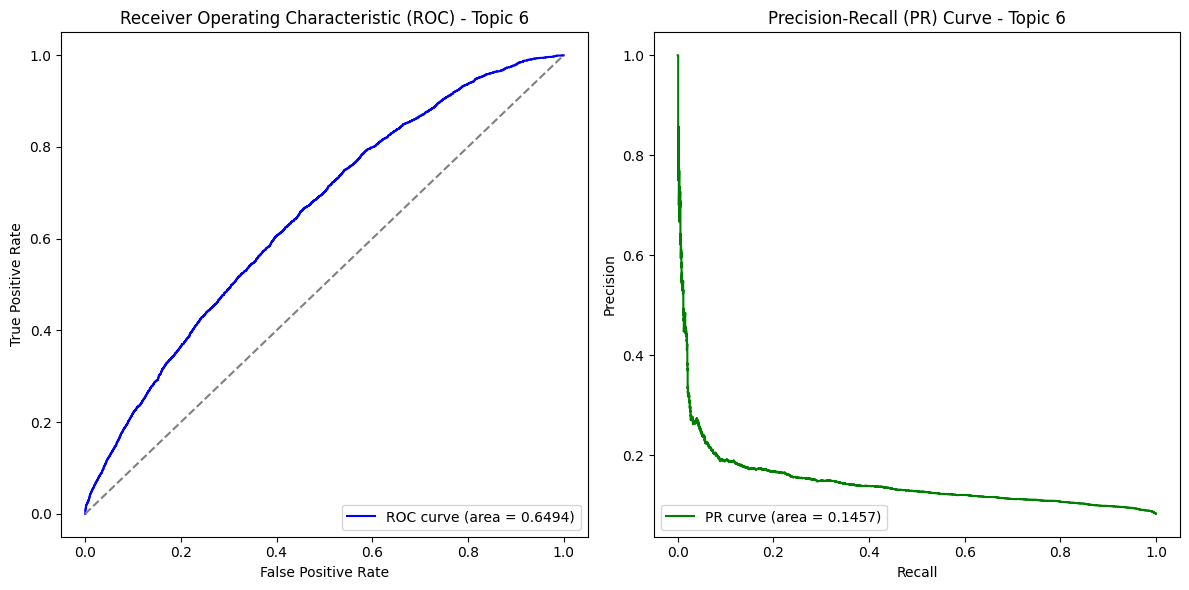

Evaluating topic 7
Topic 7 - auROC: 0.5974, auPR: 0.1350, F1: 0.0203


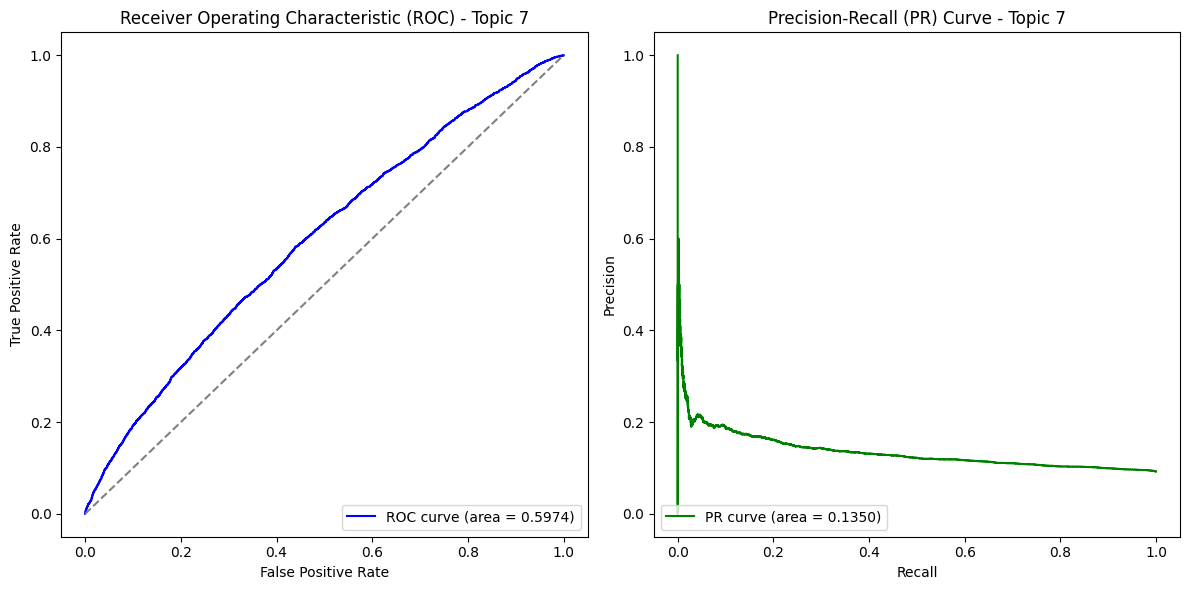

Evaluating topic 8
Topic 8 - auROC: 0.6003, auPR: 0.1221, F1: 0.0095


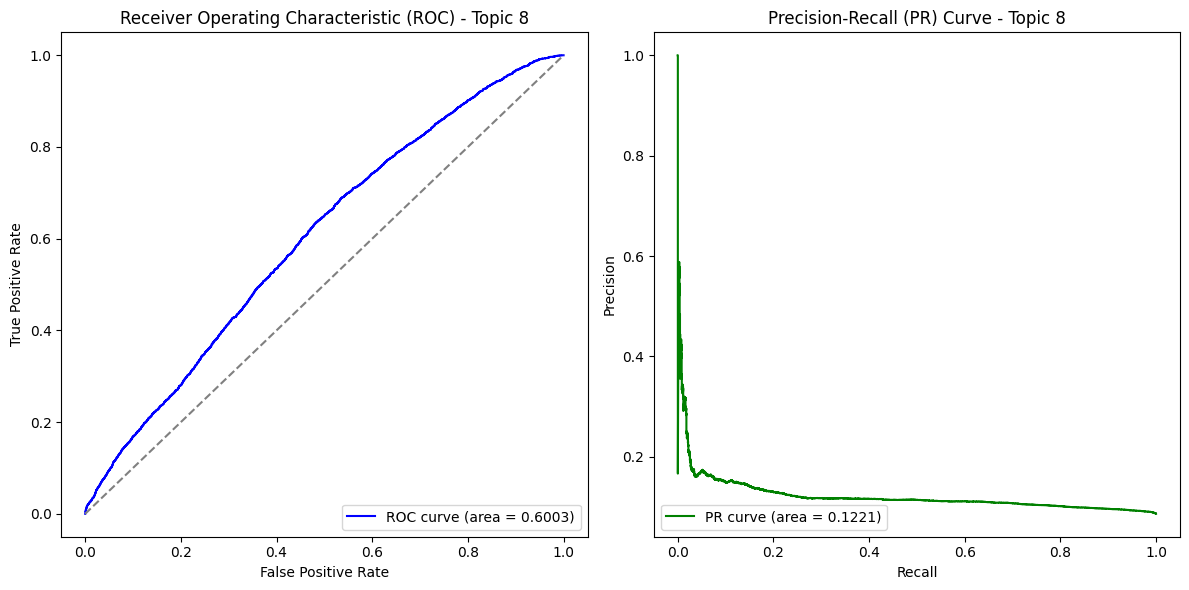

Evaluating topic 9
Topic 9 - auROC: 0.5973, auPR: 0.1305, F1: 0.0248


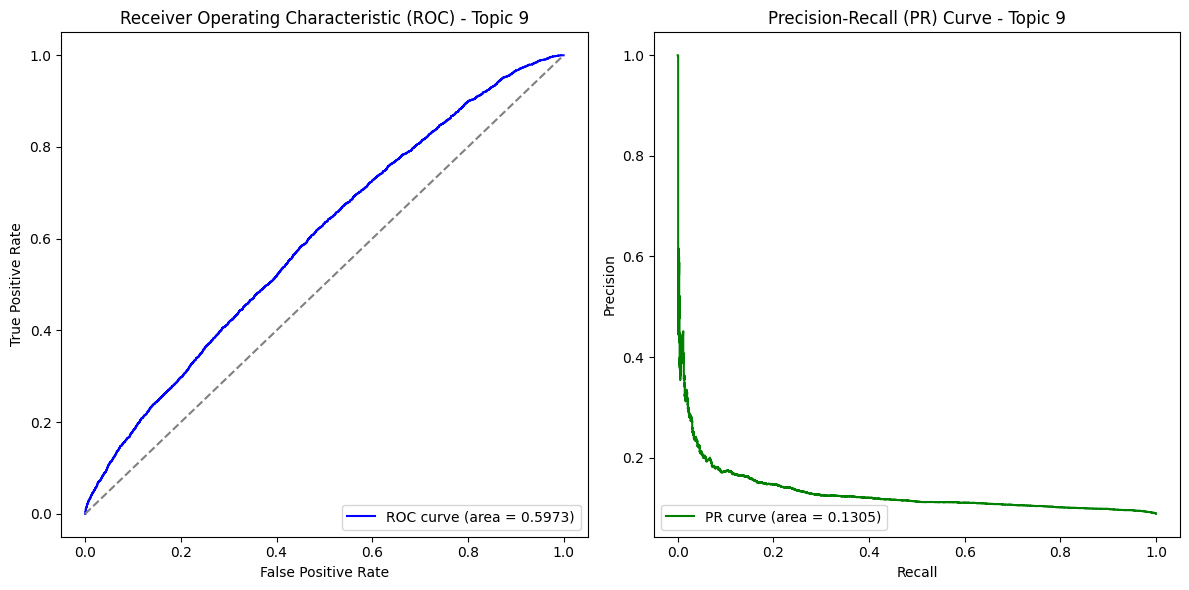

Evaluating topic 10
Topic 10 - auROC: 0.6763, auPR: 0.1736, F1: 0.0104


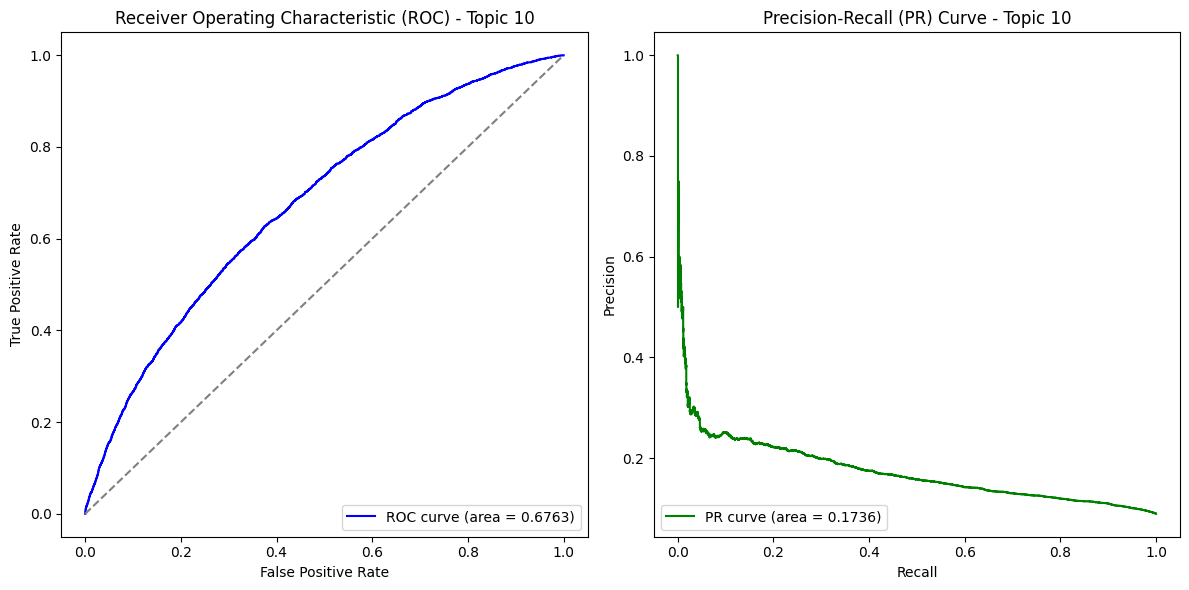

Evaluating topic 11
Topic 11 - auROC: 0.5923, auPR: 0.1204, F1: 0.0078


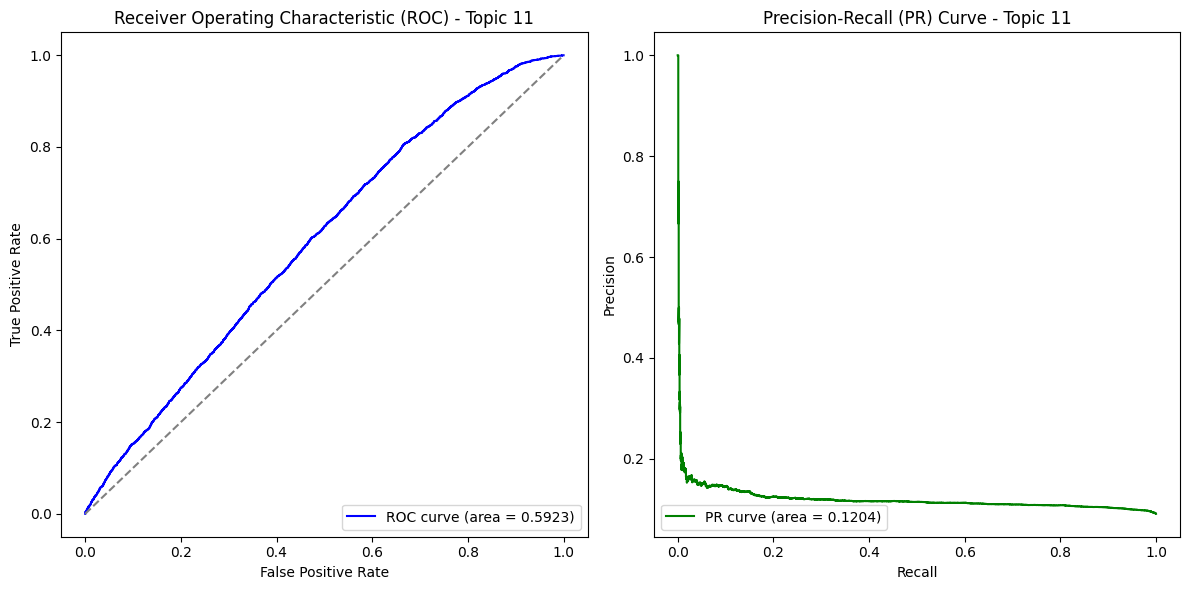

Evaluating topic 12
Topic 12 - auROC: 0.5813, auPR: 0.1234, F1: 0.0093


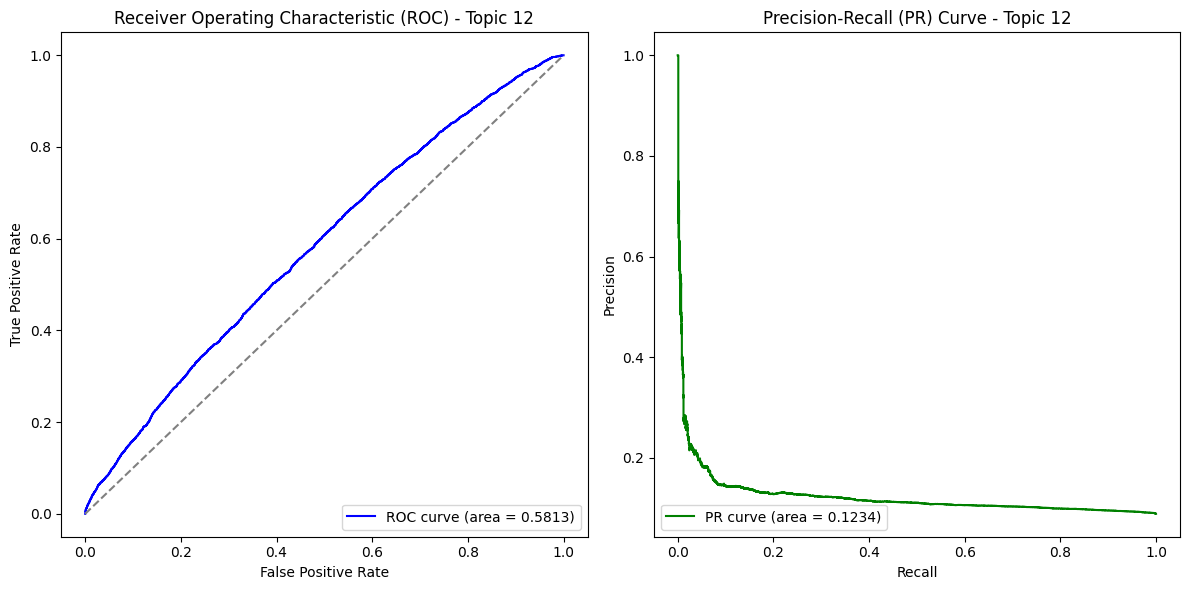

Evaluating topic 13
Topic 13 - auROC: 0.5677, auPR: 0.1191, F1: 0.0091


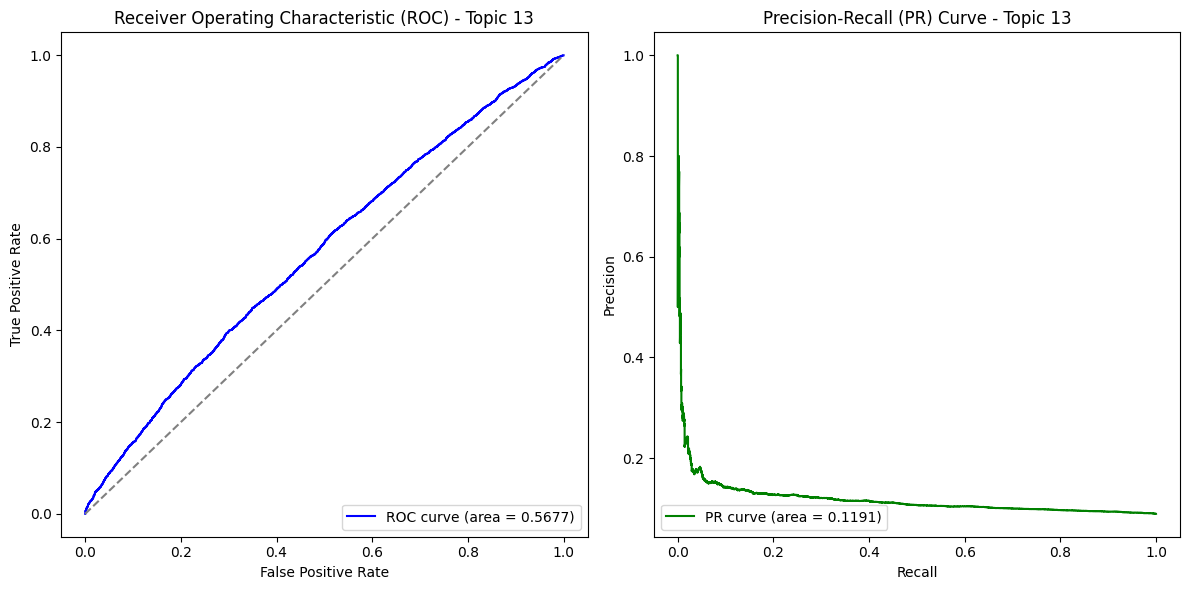

Evaluating topic 14
Topic 14 - auROC: 0.6191, auPR: 0.1300, F1: 0.0141


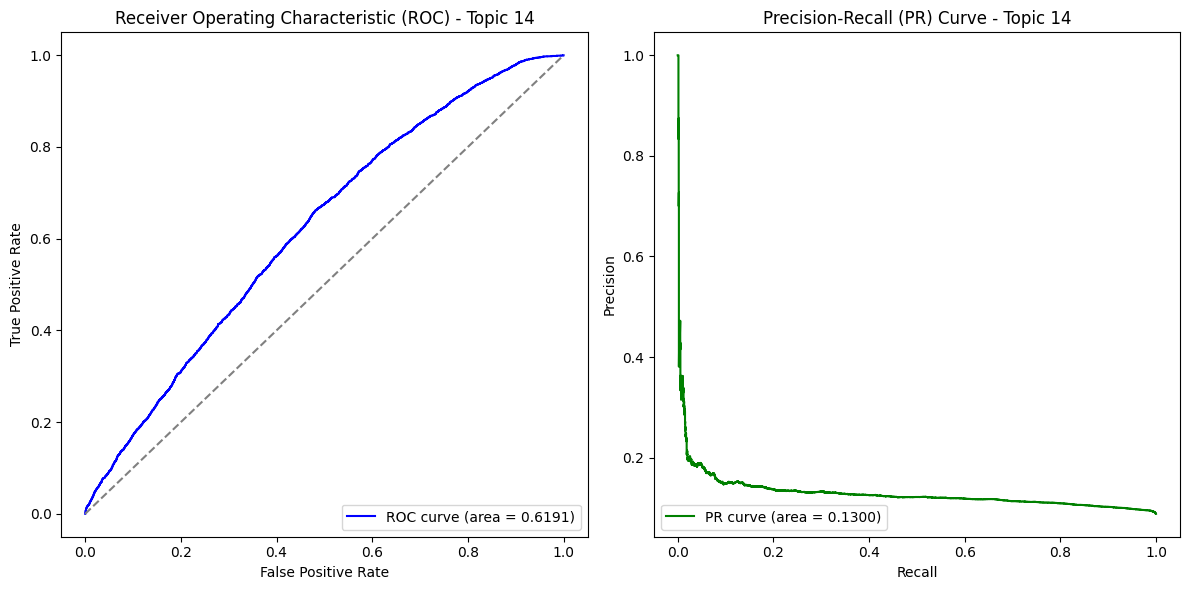

In [19]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [20]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.6306 ± 0.0464
Mean auPR: 0.1589 ± 0.0682
Mean F1: 0.0406 ± 0.0911
Exact Match Accuracy: 0.0231
Hamming Accuracy: 0.9111


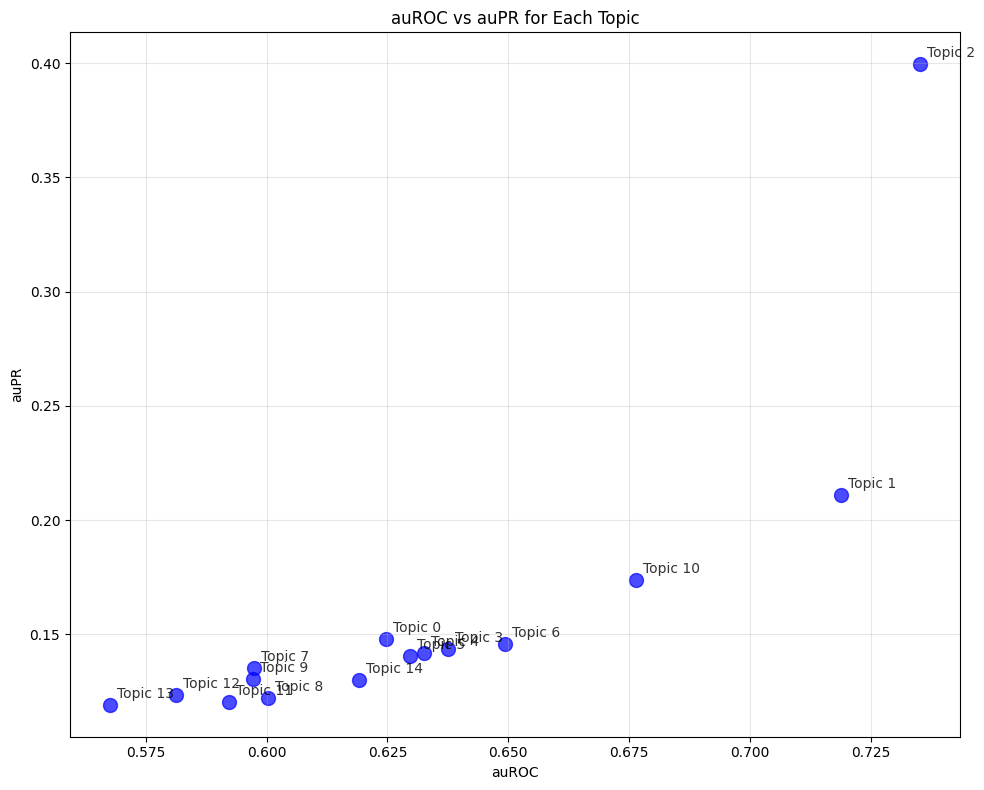

In [21]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

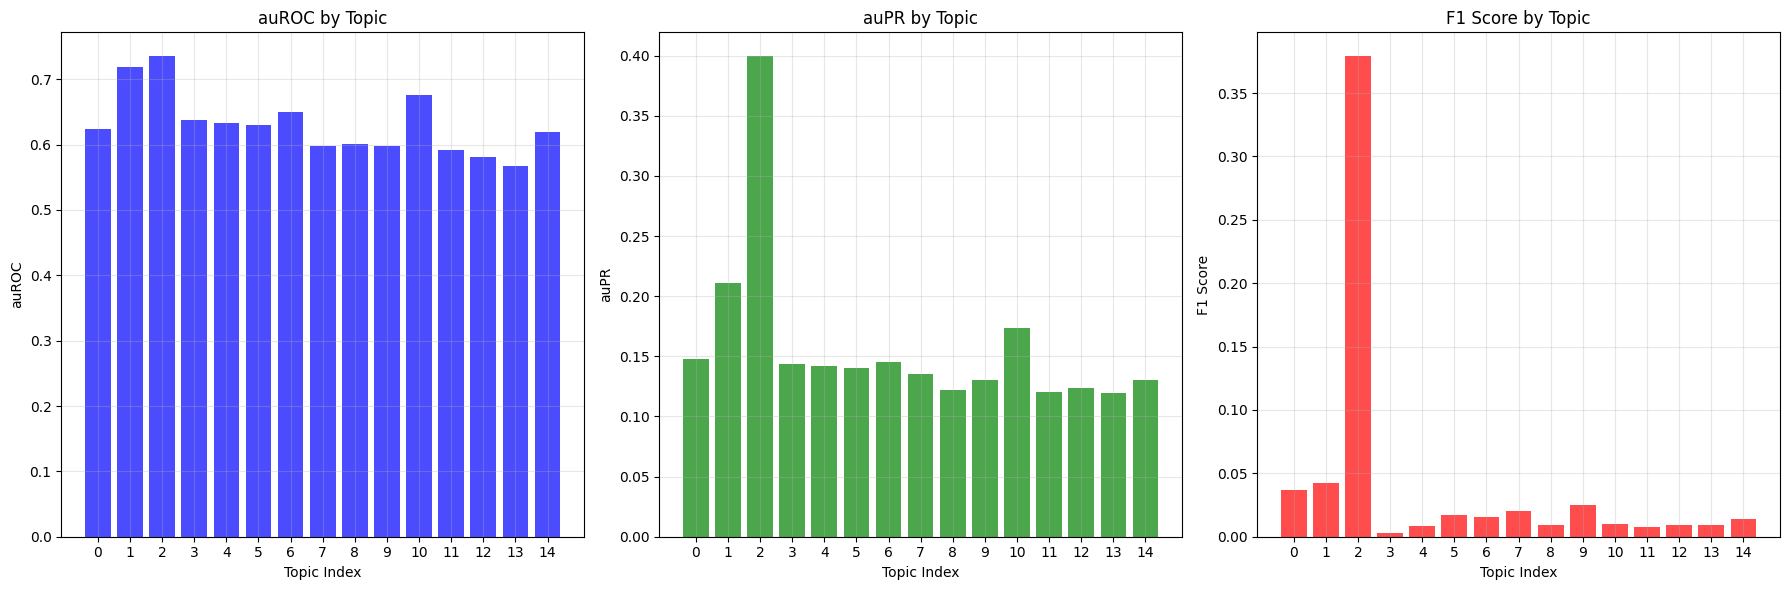

In [22]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

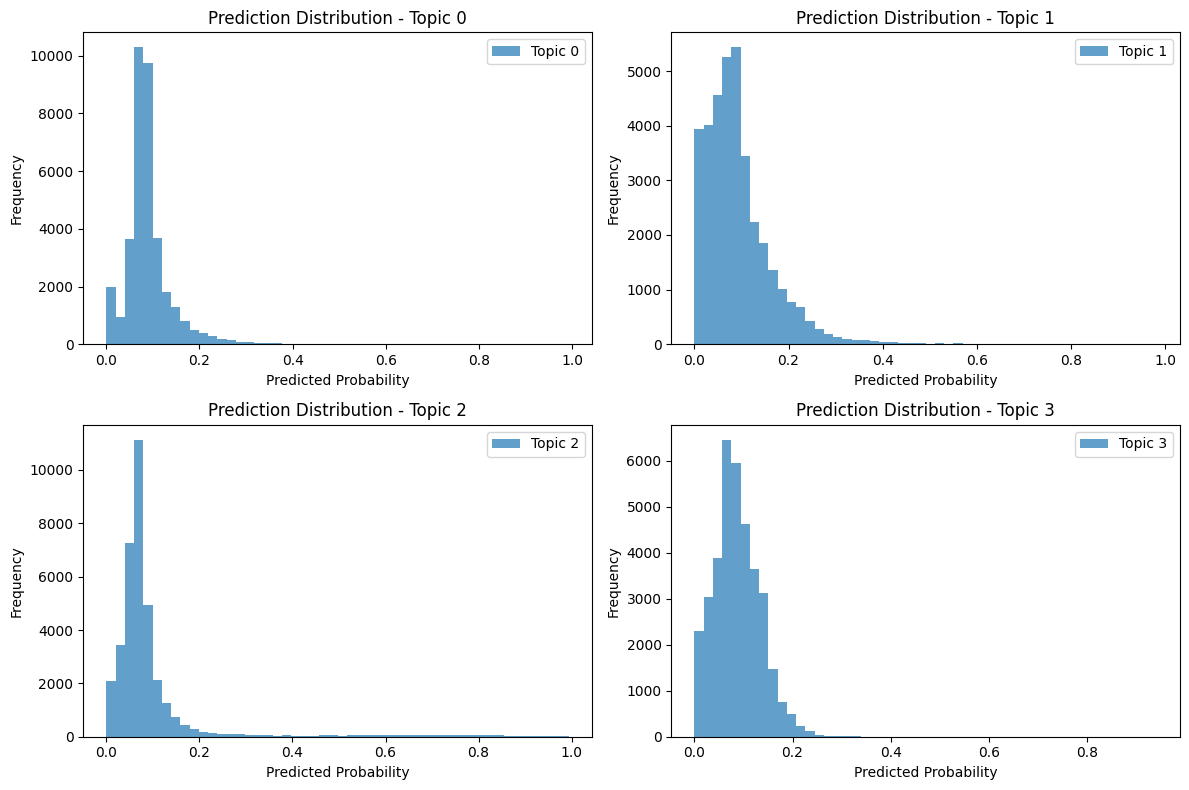


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.05982309 0.10124578 0.07929959 0.07446264 0.06621566 0.06804798
 0.13268077 0.08312645 0.10991213 0.10272378 0.05334982 0.08842309
 0.10496564 0.12742874 0.15440886]
  Actual:    [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 1:
  Predicted: [0.07639103 0.13811556 0.05823123 0.06474519 0.06842502 0.08173464
 0.12360677 0.07748603 0.09094178 0.0818243  0.04542266 0.1125289
 0.11530508 0.10099411 0.13466133]
  Actual:    [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.07036003 0.2197365  0.00947034 0.00861388 0.01004548 0.01486428
 0.16814609 0.13197482 0.09977666 0.04745626 0.02321076 0.06021101
 0.12885374 0.04984092 0.05521441]
  Actual:    [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 3:
  Predicted: [0.06372654 0.08755253 0.07240795 0.07527594

In [23]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()

In [24]:
# Evaluate model on entire dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in test_dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(test_dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [25]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 8.911451e-09 0.99070674
Prediction shape: (5429, 15)
Target shape: (5429, 15)


In [26]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0866
Topic 1: 0.0952
Topic 2: 0.0890
Topic 3: 0.0941
Topic 4: 0.0904
Topic 5: 0.0869
Topic 6: 0.0807
Topic 7: 0.0860
Topic 8: 0.0904
Topic 9: 0.0939
Topic 10: 0.0932
Topic 11: 0.0989
Topic 12: 0.0864
Topic 13: 0.0928
Topic 14: 0.0849


In [27]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[4943   16]
 [ 467    3]]

Topic 1:
[[4897   15]
 [ 509    8]]

Topic 2:
[[4884   62]
 [ 370  113]]

Topic 3:
[[4916    2]
 [ 511    0]]

Topic 4:
[[4935    3]
 [ 489    2]]

Topic 5:
[[4946   11]
 [ 472    0]]

Topic 6:
[[4988    3]
 [ 437    1]]

Topic 7:
[[4947   15]
 [ 467    0]]

Topic 8:
[[4933    5]
 [ 491    0]]

Topic 9:
[[4903   16]
 [ 507    3]]

Topic 10:
[[4921    2]
 [ 505    1]]

Topic 11:
[[4887    5]
 [ 537    0]]

Topic 12:
[[4957    3]
 [ 468    1]]

Topic 13:
[[4921    4]
 [ 504    0]]

Topic 14:
[[4959    9]
 [ 460    1]]



Evaluating 15 topics...
Evaluating topic 0
Topic 0 - auROC: 0.5701, auPR: 0.1110, F1: 0.0123


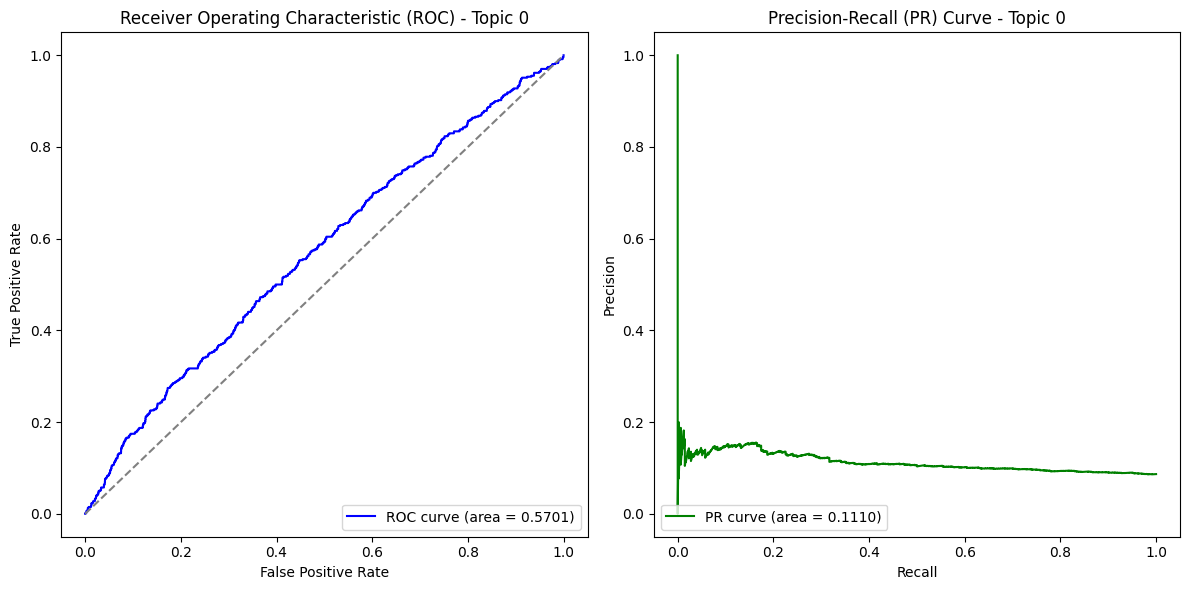

Evaluating topic 1
Topic 1 - auROC: 0.6918, auPR: 0.1902, F1: 0.0296


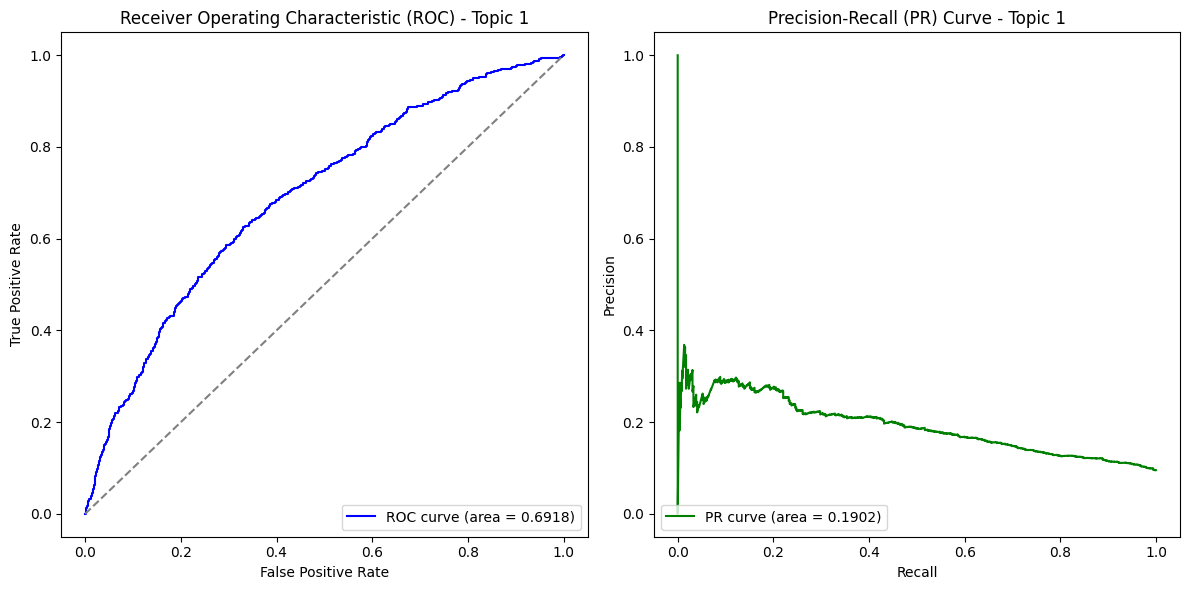

Evaluating topic 2
Topic 2 - auROC: 0.7224, auPR: 0.3470, F1: 0.3435


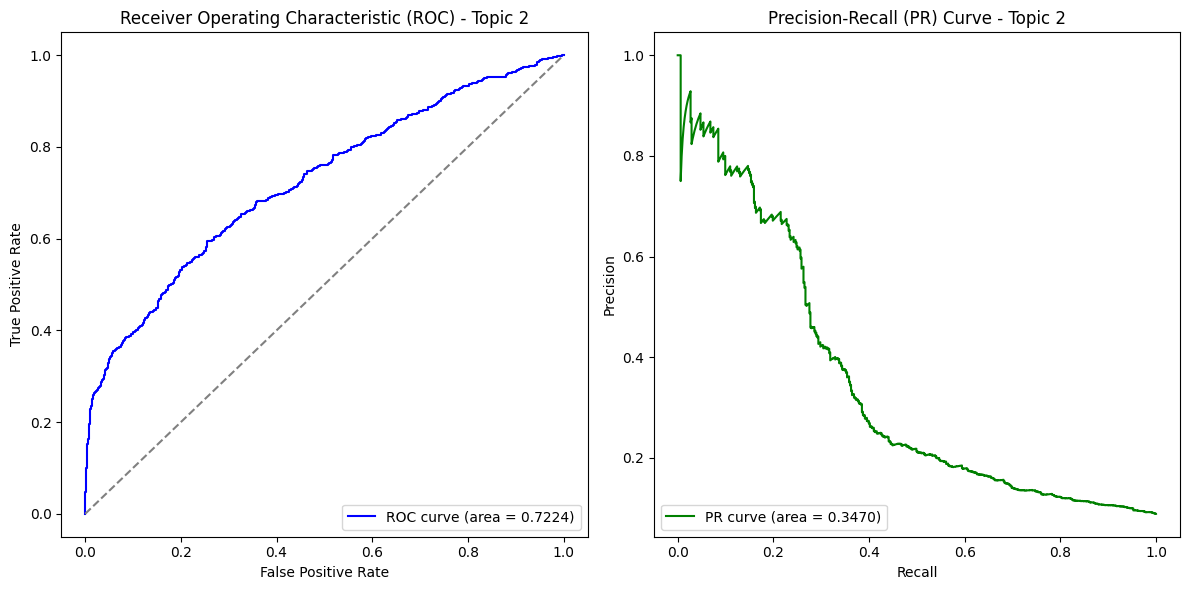

Evaluating topic 3
Topic 3 - auROC: 0.6210, auPR: 0.1335, F1: 0.0000


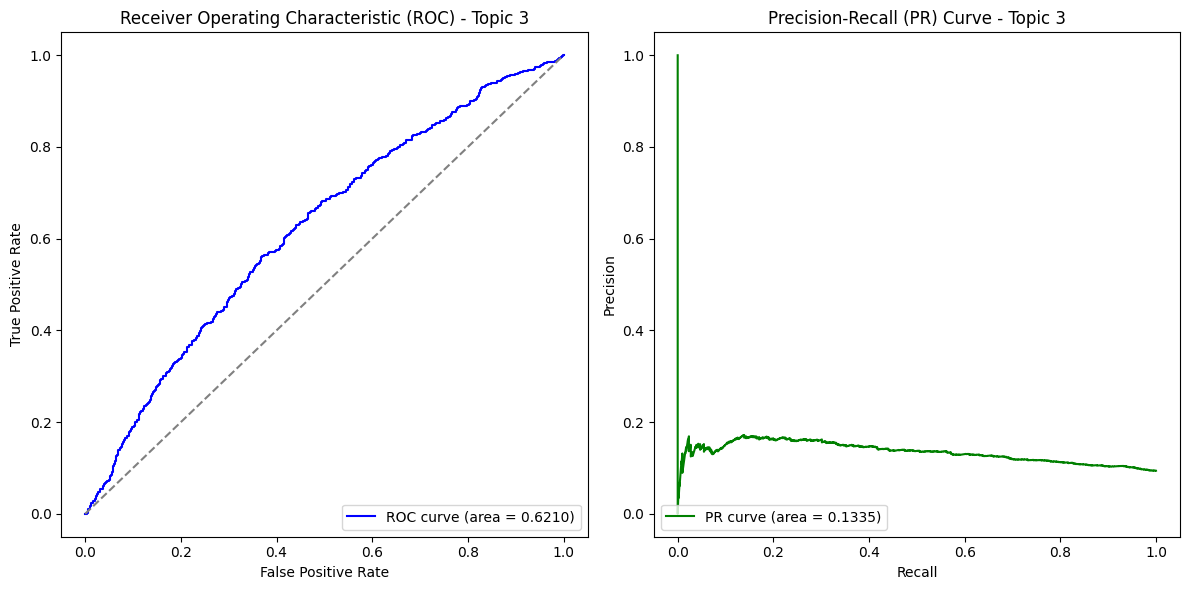

Evaluating topic 4
Topic 4 - auROC: 0.6127, auPR: 0.1280, F1: 0.0081


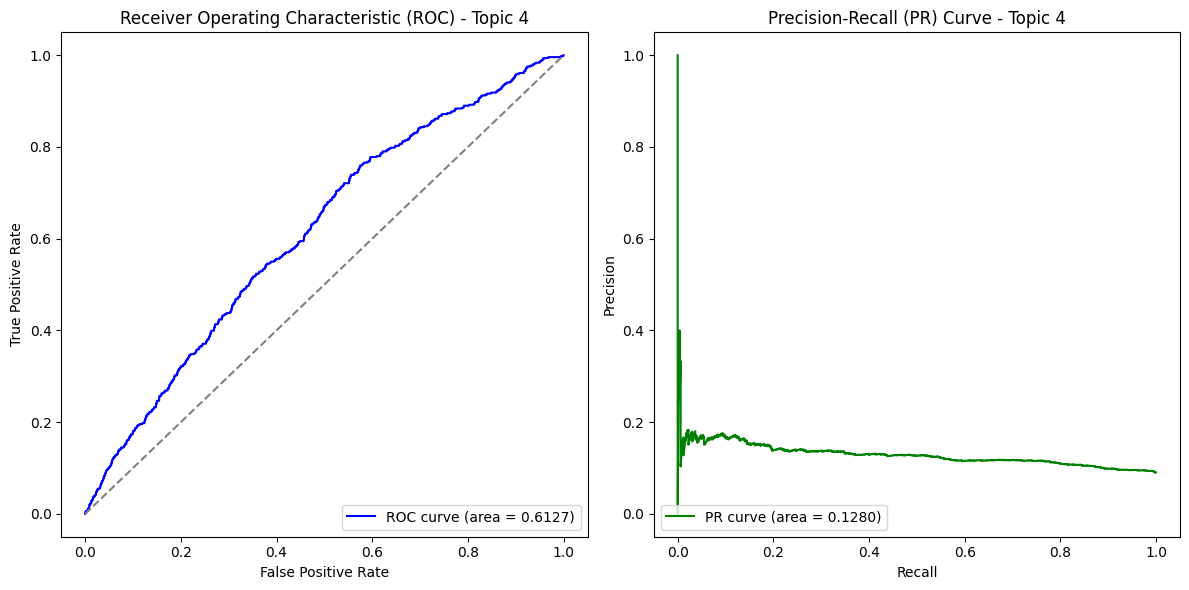

Evaluating topic 5
Topic 5 - auROC: 0.5927, auPR: 0.1129, F1: 0.0000


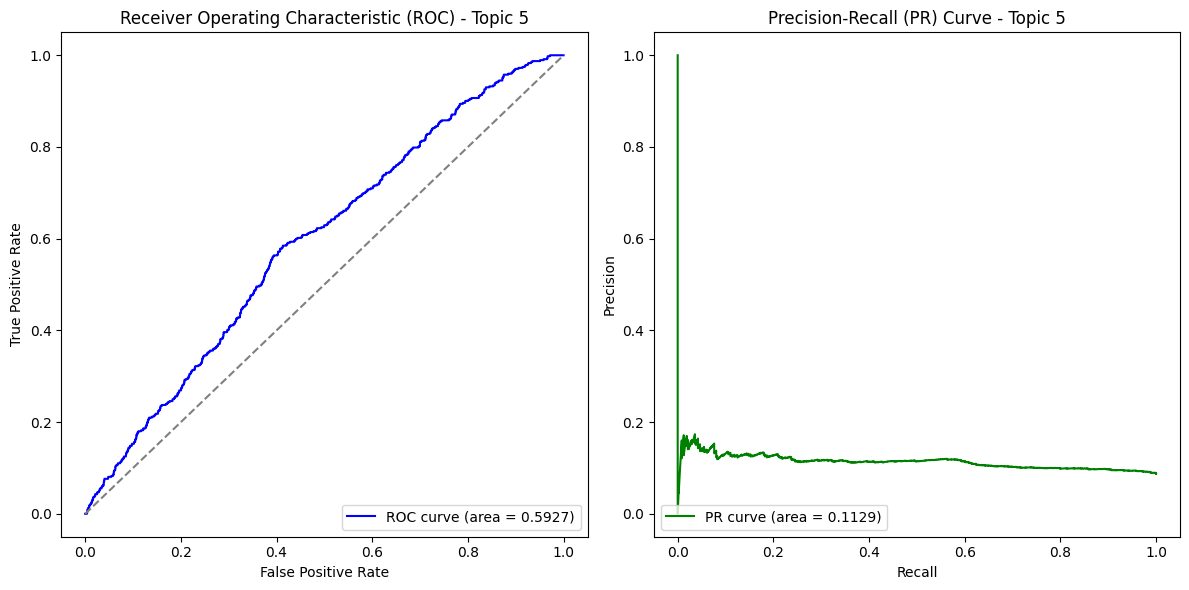

Evaluating topic 6
Topic 6 - auROC: 0.6000, auPR: 0.1116, F1: 0.0045


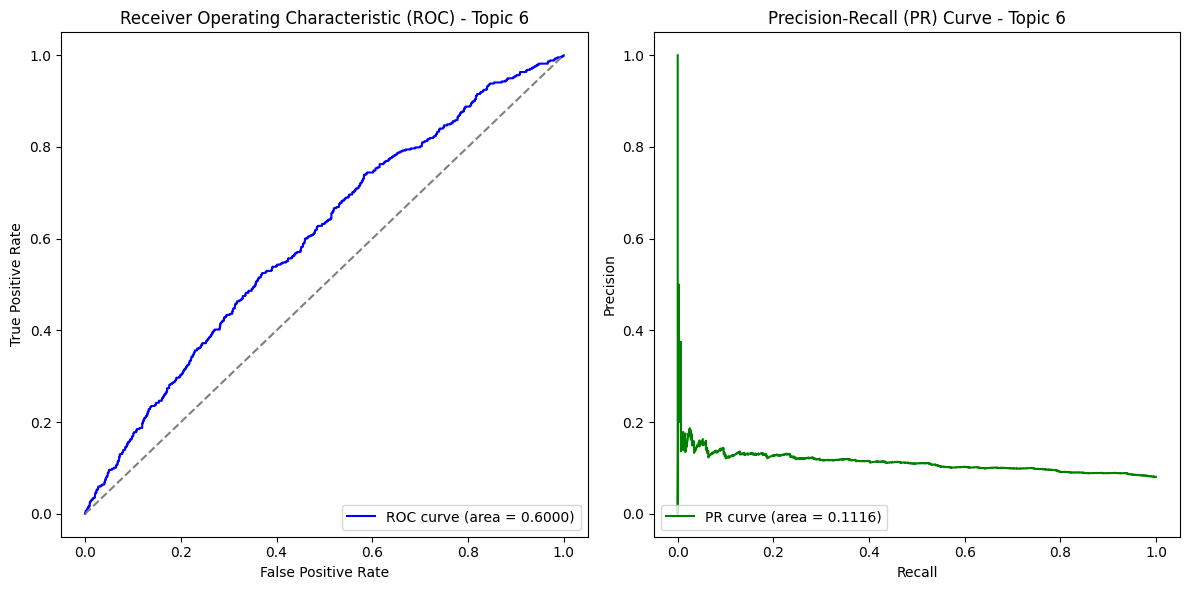

Evaluating topic 7
Topic 7 - auROC: 0.5362, auPR: 0.0989, F1: 0.0000


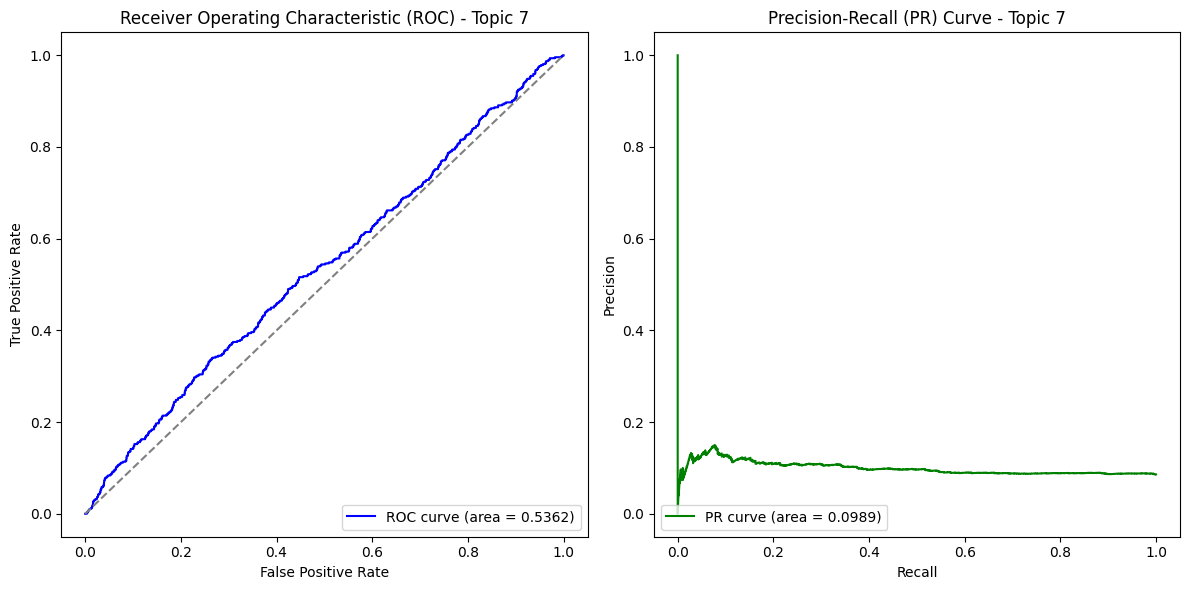

Evaluating topic 8
Topic 8 - auROC: 0.5283, auPR: 0.0906, F1: 0.0000


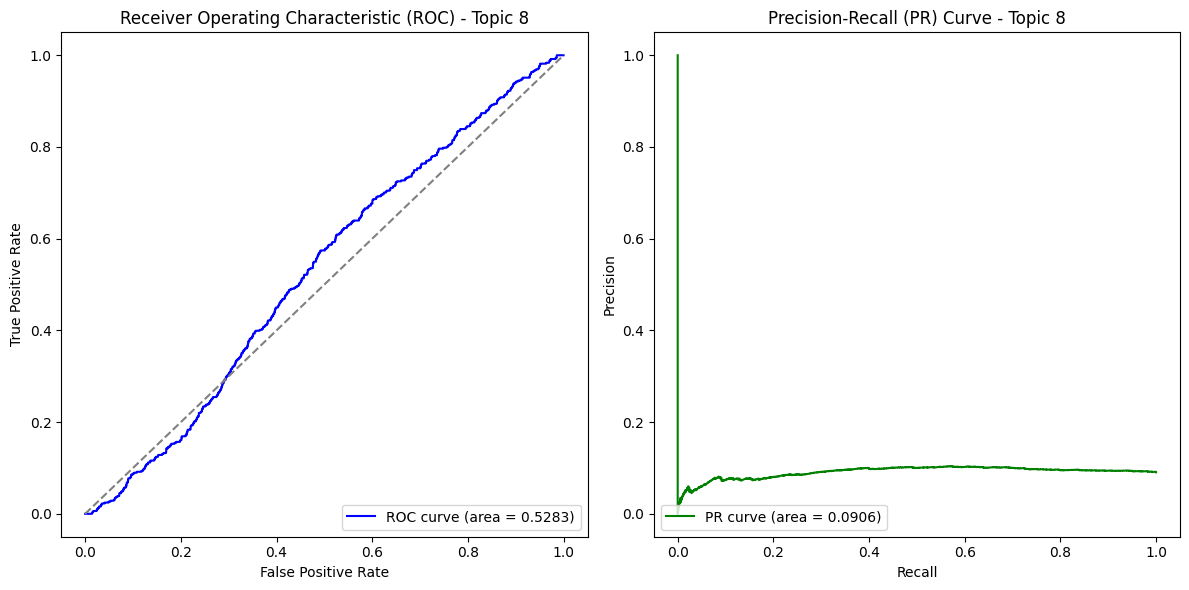

Evaluating topic 9
Topic 9 - auROC: 0.5517, auPR: 0.1144, F1: 0.0113


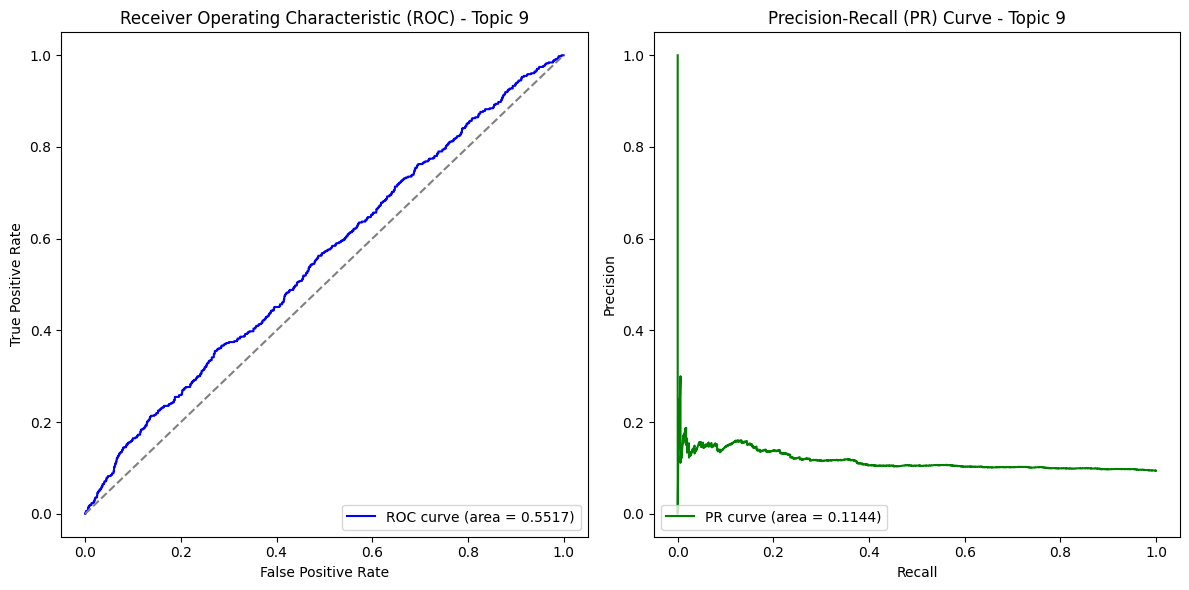

Evaluating topic 10
Topic 10 - auROC: 0.6316, auPR: 0.1469, F1: 0.0039


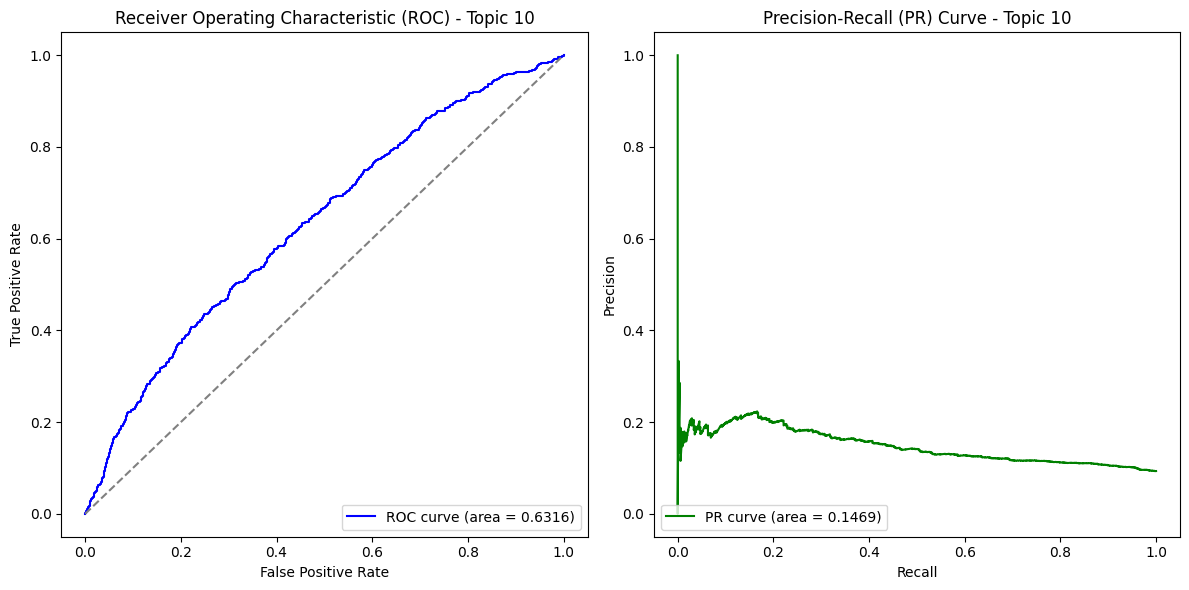

Evaluating topic 11
Topic 11 - auROC: 0.5341, auPR: 0.1024, F1: 0.0000


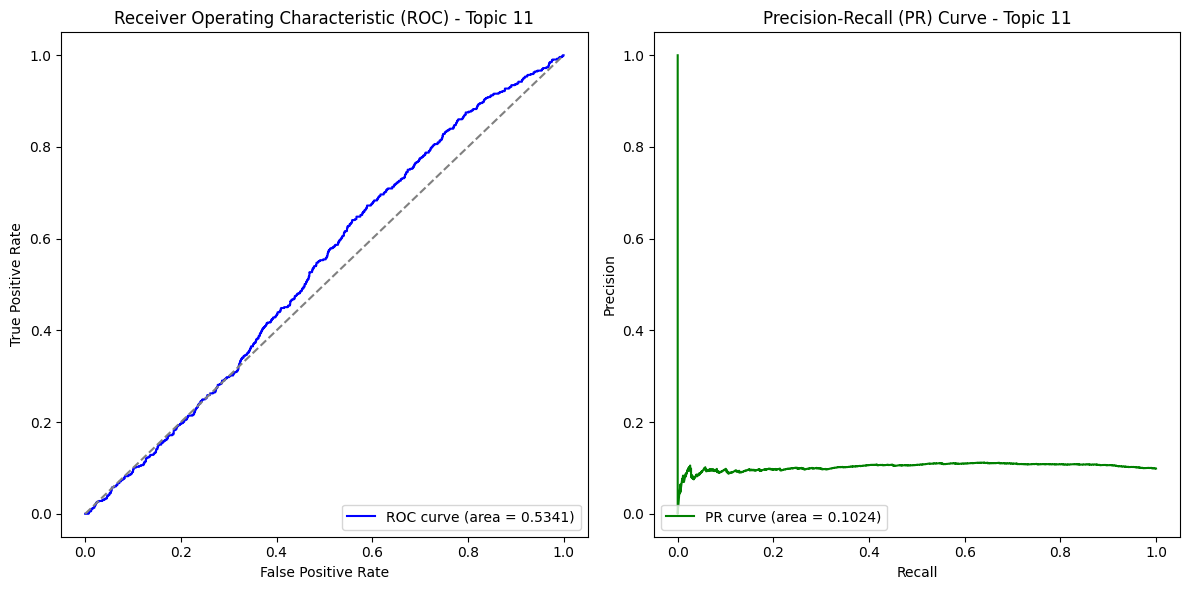

Evaluating topic 12
Topic 12 - auROC: 0.5607, auPR: 0.1086, F1: 0.0042


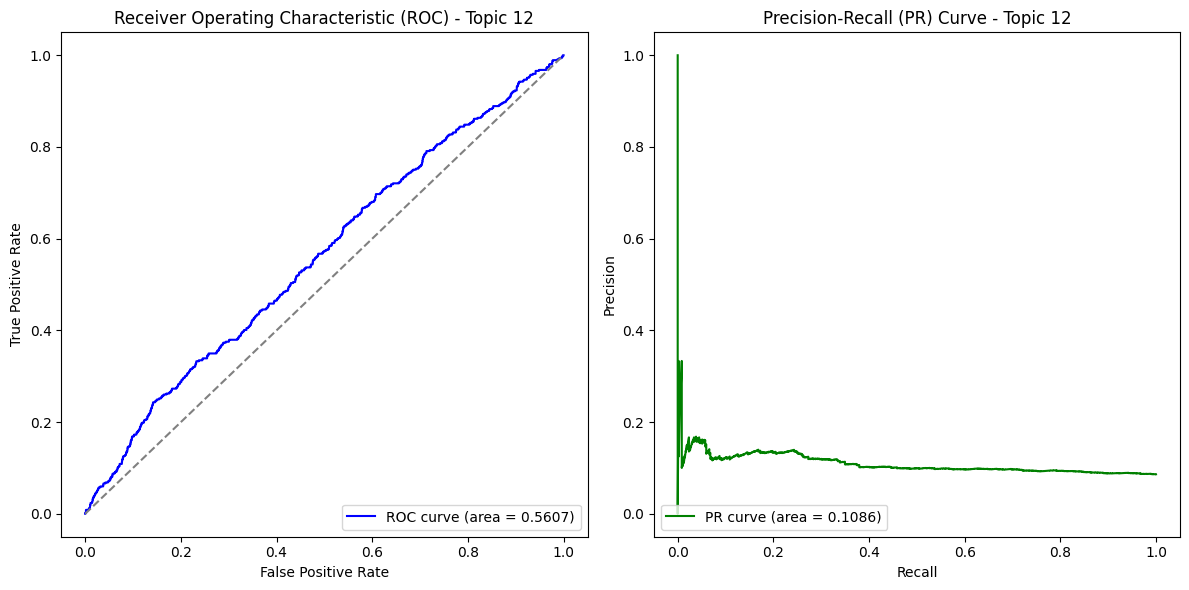

Evaluating topic 13
Topic 13 - auROC: 0.4872, auPR: 0.0916, F1: 0.0000


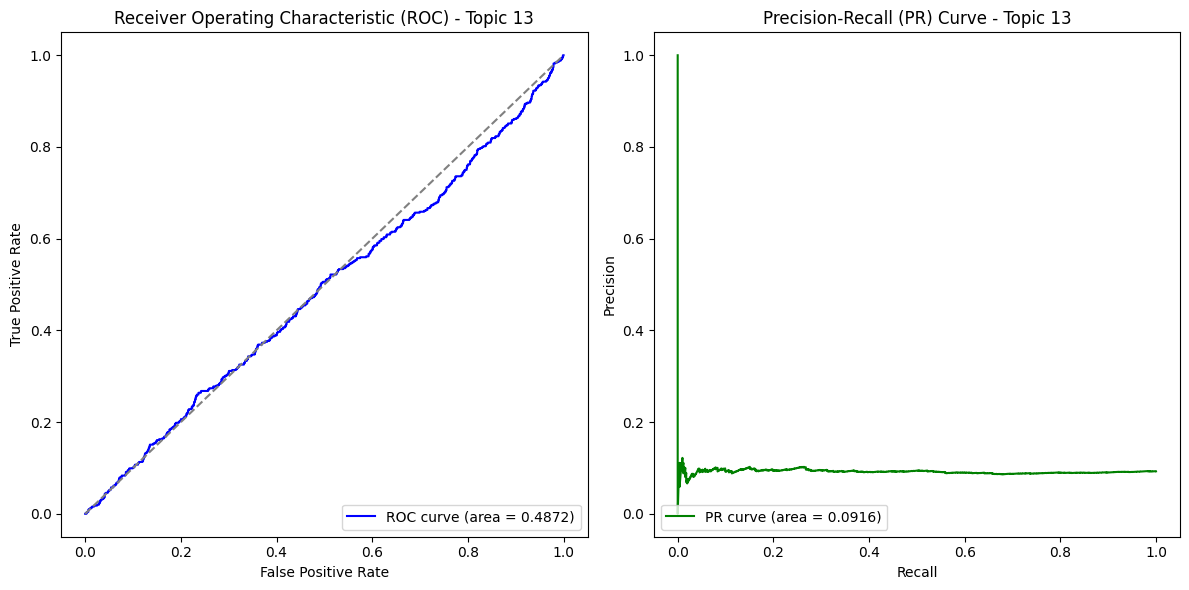

Evaluating topic 14
Topic 14 - auROC: 0.5679, auPR: 0.1012, F1: 0.0042


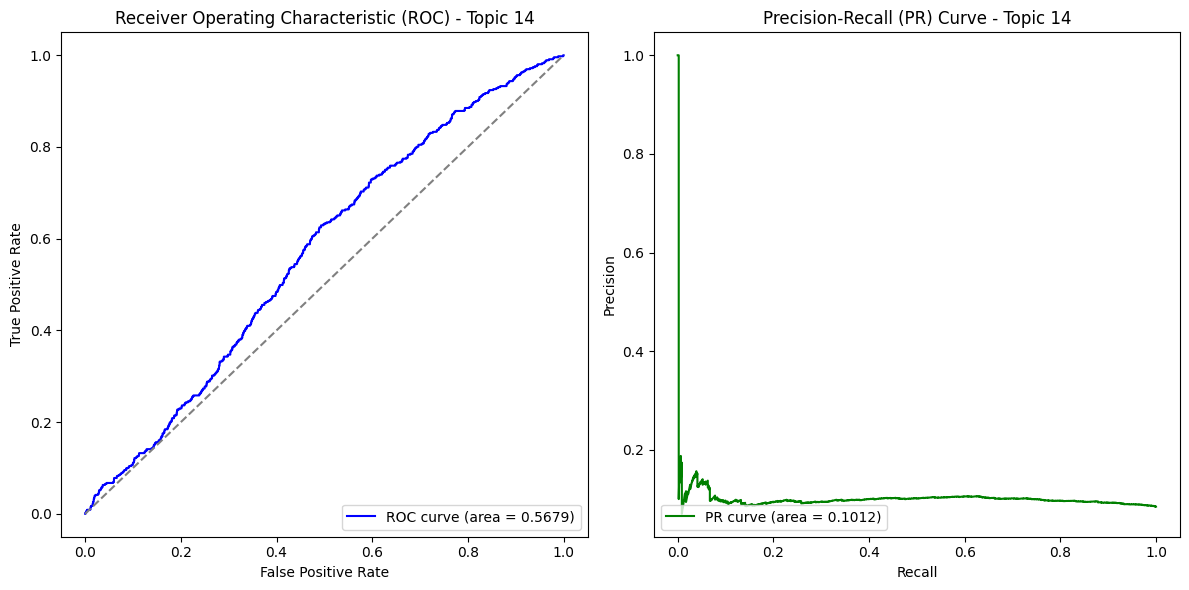

In [28]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [29]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.5872 ± 0.0604
Mean auPR: 0.1326 ± 0.0623
Mean F1: 0.0281 ± 0.0846
Exact Match Accuracy: 0.0025
Hamming Accuracy: 0.9096


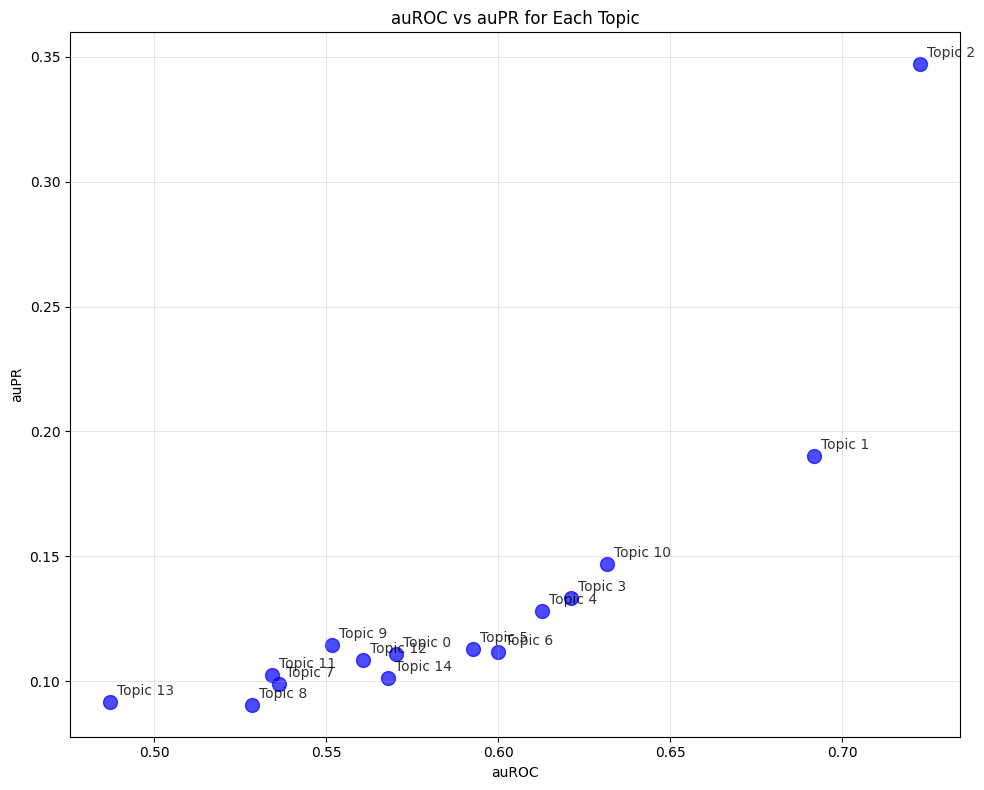

In [30]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

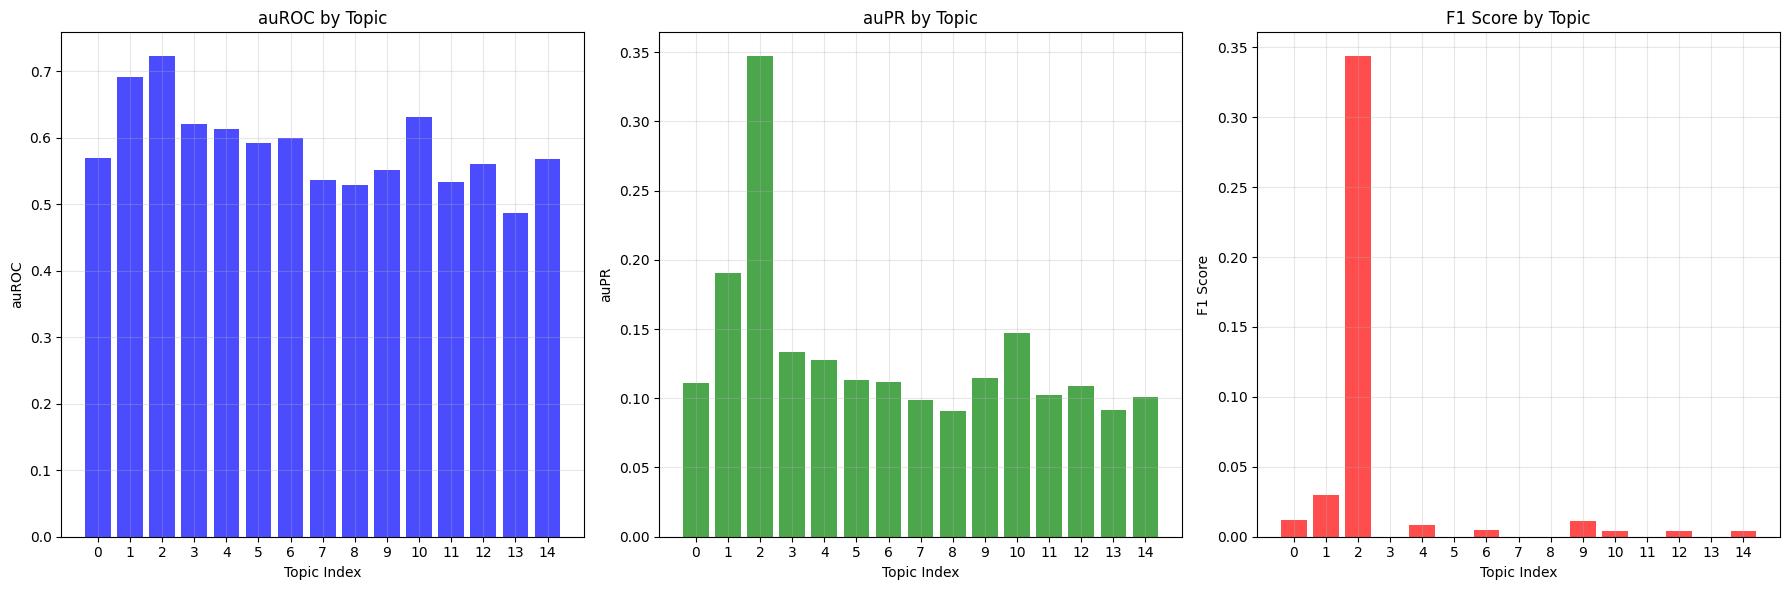

In [31]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

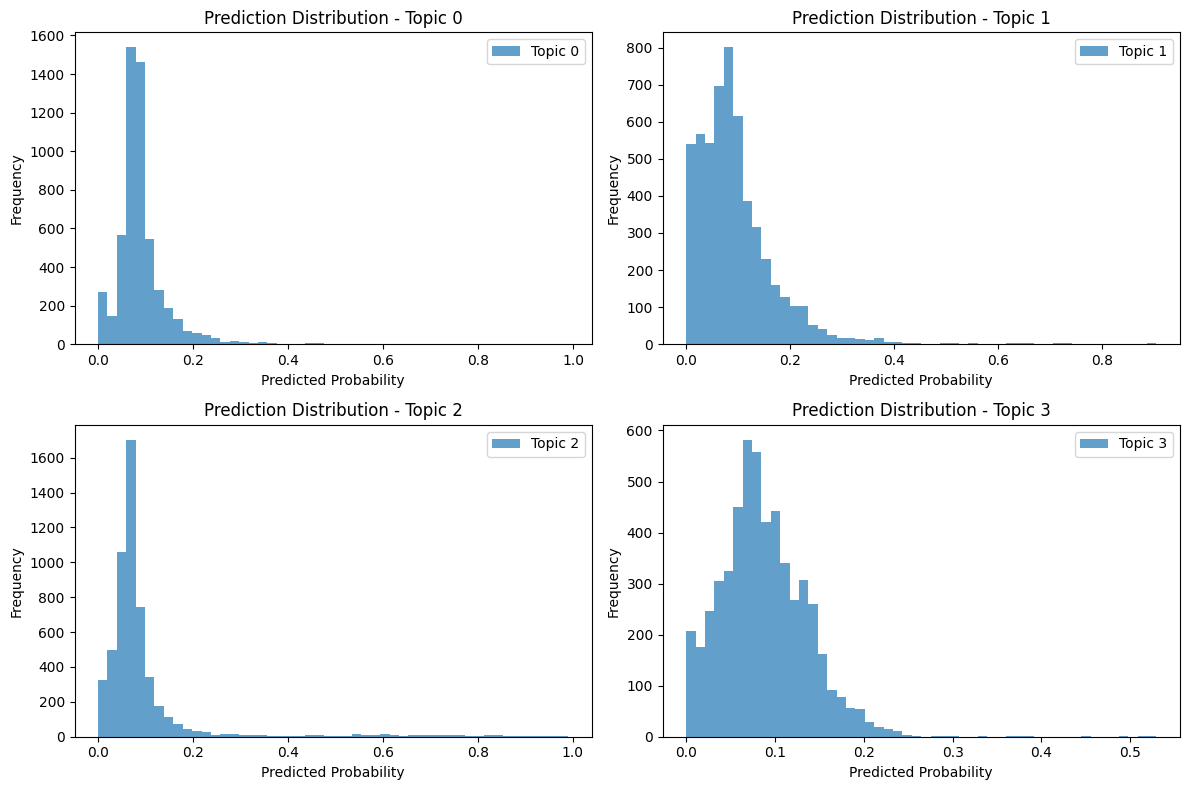


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.06372803 0.1302909  0.06517558 0.0560254  0.06366807 0.05454624
 0.12406058 0.09287701 0.11743724 0.08783432 0.03533103 0.08283881
 0.09260055 0.12572035 0.13289814]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 1:
  Predicted: [0.05988935 0.01349732 0.11190558 0.18906114 0.1623411  0.10016876
 0.01723497 0.07990071 0.03886201 0.0660802  0.2503644  0.0540718
 0.05724214 0.07805769 0.04220561]
  Actual:    [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.08031662 0.08328762 0.06771951 0.09805981 0.10256862 0.0922441
 0.08558273 0.08105193 0.09803598 0.08683532 0.06491026 0.10951257
 0.10314905 0.09956399 0.11543731]
  Actual:    [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 3:
  Predicted: [0.05155274 0.09205547 0.06190417 0.07437778 

In [32]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()